In [1]:
import cv2
import os, re
import numpy as np
import scipy
from scipy.special import gamma
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# from DHTVPac.HTV_Delaunay import *
# from DHTVPac.MyPloter import *

In [2]:
class cpwl_net(nn.Module): 

    def __init__(self, d, n_points):
        
        super(cpwl_net, self).__init__()
        self.layer1 = nn.Linear(d, n_points)
        self.layer2 = nn.Linear(n_points, 1)

    def set_weigh_bias(self, W, b, a_k): 
        
        self.layer1.weight.requires_grad = False
        self.layer1.bias.requires_grad = False
        self.layer1.weight.copy_(torch.from_numpy(W))
        self.layer1.bias.copy_(torch.from_numpy(b))

        self.layer2.weight.requires_grad = False
        self.layer2.bias.requires_grad = False
        self.layer2.weight.copy_(torch.from_numpy(a_k))
        self.layer2.bias.copy_(torch.Tensor([0]))

    def forward(self, x): 
        return self.layer2(F.relu(self.layer1(x)))

In [3]:
np.random.seed(2021)

d, l, r = 2, 10, 1 # dimension, lenght, radius
area_sphere = (2 * np.pi) ** (d / 2) / gamma((d / 2)) * r ** (d - 1) # the area of a 2-sphere
area_cylinder = area_sphere * l # the area of the 3-cylinder of length l
lmbda = 1000
eps = 1e-7

for i in range(5):
    lam_pois = lmbda # * area_cylinder

    K = np.random.poisson(lam=lam_pois)
    A_k = np.random.normal(1, K, size=(K)) # Impulsions magnitude
    # A_k = np.random.exponential(2, size=(K))

    X = np.random.normal(0, 1, size=(K, d))
    Xi = r * X / np.linalg.norm(X, 2, axis=1)[:, None] # Uniformly distributed over the hyper-sphere
    t = np.random.uniform(-l/2, l/2, size=(K))

    b_0 = - A_k * (np.abs(t) - t) / 2 
    b_0 = b_0.sum()
    b = - A_k[:, None] * (1 + np.sign(t))[:, None] * Xi / 2
    b = np.sum(b, axis=0)[:, None]

    cpwl_network = cpwl_net(d, K)
    cpwl_network.set_weigh_bias(Xi, t, A_k)

    nx, ny = (400, 400)
    x = np.linspace(-1, 1, nx) # recheck this range
    y = np.linspace(-1, 1, ny) # recheck this range
    xv, yv = np.meshgrid(x, y)
    coords = np.concatenate((xv.flatten()[:, None], yv.flatten()[:, None]), axis=1)

    vals = b_0 + coords @ b + cpwl_network(torch.from_numpy(coords).float()).numpy() # if tst == 0 else vals + b_0 + coords @ b + cpwl_network(torch.from_numpy(coords).float()).numpy()
    vals_image = np.fliplr(vals.reshape((nx, ny)))

    plt.imsave('images/img' + str(i) + '.png', vals_image[:1080, :1920])
    delta_h_img = scipy.signal.convolve2d(vals_image, np.array([[1, -1]]), mode='same')
    delta_v_img = scipy.signal.convolve2d(vals_image, np.array([[-1], [1]]), mode='same')
    
    grad = np.sqrt(delta_h_img ** 2 + delta_v_img ** 2)[5:-5, 5:-5] # clipping

    plt.imsave('images/grd' + str(i) + '.png', grad[:1080, :1920])

    vals_image = vals_image[5:-5, 5:-5]
    vals_image = (vals_image - np.min(vals) + eps) / (np.max(vals) - np.min(vals) + eps)

    grad = (grad - np.min(grad) + eps) / (np.max(grad) - np.min(grad) + eps)
    img_grad = np.hstack((vals_image, grad))

    plt.imsave('images/img_grd' + str(i) + '.png', img_grad)

In [4]:
# Movie_2D
np.random.seed(2021)

d, l, r = 2, 5, 1 # dimension, lenght, radius
area_sphere = (2 * np.pi) ** (d / 2) / gamma((d / 2)) * r ** (d - 1) # the area of a 2-sphere
area_cylinder = area_sphere * l # the area of the 3-cylinder of length l
tst = 0
eps = 1e-7

for lmbda in [i for i in range(5, 10)] + [i for i in range(25, 1000, 25)] : # + [i for i in range(1000, 5000, 50)] + [i for i in range(5000, 10_000, 1_000)]:
    lam_pois = lmbda # * area_cylinder

    K = np.random.poisson(lam=lam_pois)
    A_k = np.random.normal(0, K, size=(K)) # Impulsions magnitude

    X = np.random.normal(0, 1, size=(K, d))
    Xi = r * X / np.linalg.norm(X, 2, axis=1)[:, None] # Uniformly distributed over the hyper-sphere
    t = np.random.uniform(-l/2, l/2, size=(K))

    b_0 = - A_k * (np.abs(t) - t) / 2 
    b_0 = b_0.sum()
    b = - A_k[:, None] * (1 + np.sign(t))[:, None] * Xi / 2
    b = np.sum(b, axis=0)[:, None]

    cpwl_network = cpwl_net(d, K)
    cpwl_network.set_weigh_bias(Xi, t, A_k)

    nx, ny = (400, 400)
    x = np.linspace(-1, 1, nx) # recheck this range
    y = np.linspace(-1, 1, ny) # recheck this range
    xv, yv = np.meshgrid(x, y)
    coords = np.concatenate((xv.flatten()[:, None], yv.flatten() [:, None]), axis=1)

    vals = b_0 + coords @ b + cpwl_network(torch.from_numpy(coords).float()).numpy() # if tst == 0 else vals + b_0 + coords @ b + cpwl_network(torch.from_numpy(coords).float()).numpy()
    vals_image = np.fliplr(vals.reshape((nx, ny)))

    plt.imsave('movie_2D/img' + str(lmbda) + '.png', vals_image[:1080, :1920])
    delta_h_img = scipy.signal.convolve2d(vals_image, np.array([[1, -1]]), mode='same')
    delta_v_img = scipy.signal.convolve2d(vals_image, np.array([[-1], [1]]), mode='same')
    
    grad = np.sqrt(delta_h_img ** 2 + delta_v_img ** 2)[5:-5, 5:-5] # clipping

    plt.imsave('movie_2D/grd' + str(lmbda) + '.png', grad[:1080, :1920])
    
    vals_image = vals_image[5:-5, 5:-5]
    vals_image = (vals_image - np.min(vals) + eps) / (np.max(vals) - np.min(vals) + eps)

    grad = (grad - np.min(grad) + eps) / (np.max(grad) - np.min(grad) + eps)
    img_grad = np.hstack((vals_image, grad))
    plt.imsave('movie_2D/_img_grd' + str(lmbda) + '.png', img_grad)

def extract_number(string):
    match = re.search(r'\d+', string)
    if match:
        return int(match.group())
    else:
        return 0 

image_folder = 'movie_2D'
video_name1, video_name2, video_name3,  = 'img', 'grd', 'img_grd'
cat = '_center' + '.avi'

fcts = [img for img in os.listdir(image_folder) if img.startswith("img")]
grds = [img for img in os.listdir(image_folder) if img.startswith("grd")]
fct_grd = [img for img in os.listdir(image_folder) if img.startswith("_img")]

fcts = sorted(fcts, key=extract_number)
grds = sorted(grds, key=extract_number)
fct_grd = sorted(fct_grd, key=extract_number)

frame1 = cv2.imread(os.path.join(image_folder, fcts[0]))
frame2 = cv2.imread(os.path.join(image_folder, grds[0]))
frame3 = cv2.imread(os.path.join(image_folder, fct_grd[0]))

height1, width1, _ = frame1.shape
height2, width2, _ = frame2.shape
height3, width3, _ = frame3.shape

video1 = cv2.VideoWriter(video_name1 + cat, 0, 5, (width1,height1))
video2 = cv2.VideoWriter(video_name2 + cat, 0, 5, (width2,height2))
video3 = cv2.VideoWriter(video_name3 + cat, 0, 5, (width3,height3))

for image in fcts:
    video1.write(cv2.imread(os.path.join(image_folder, image)))
for image in grds:
    video2.write(cv2.imread(os.path.join(image_folder, image)))
for image in fct_grd:
    video3.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video1.release()
video2.release()
video3.release()

C:\Users\Ayoub\AppData\Local\Temp\ipykernel_7568\4051793148.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


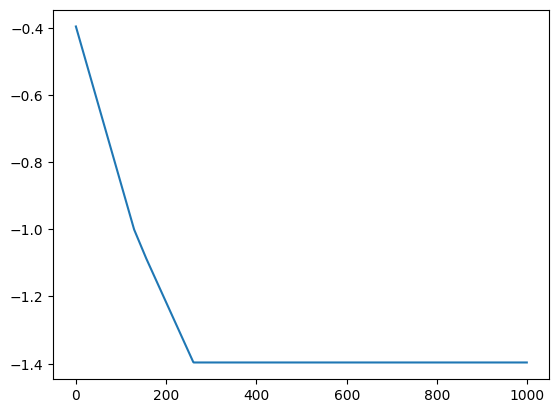

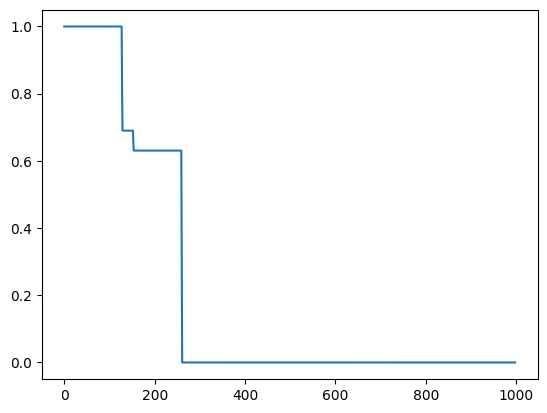

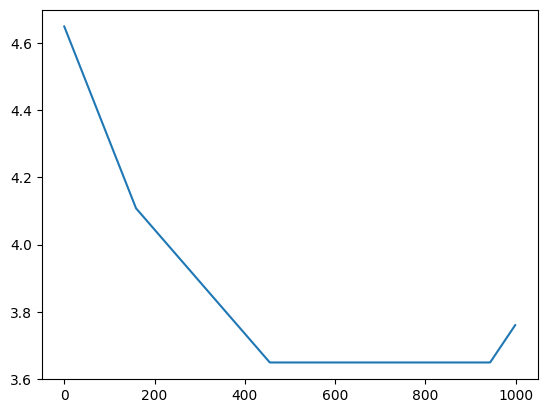

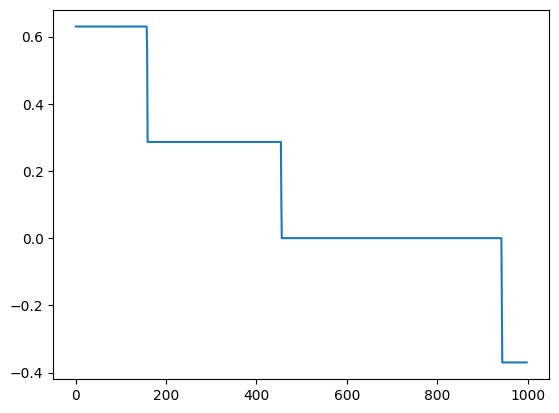

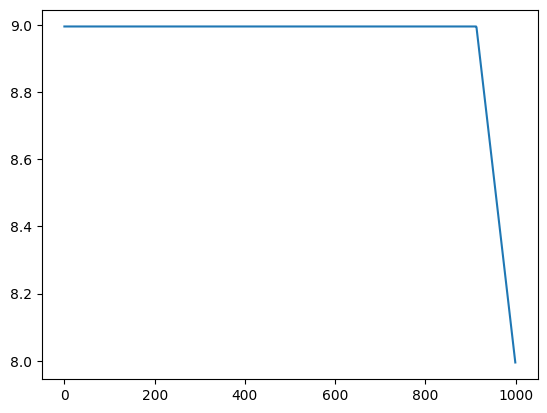

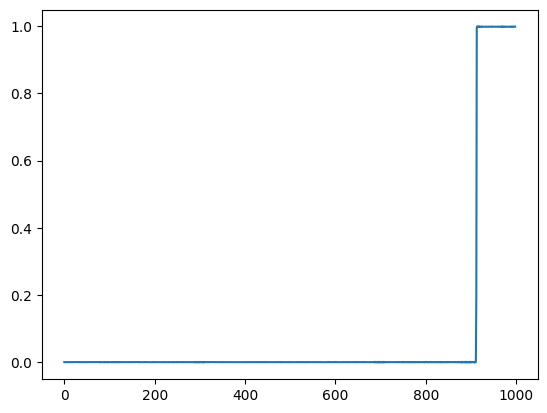

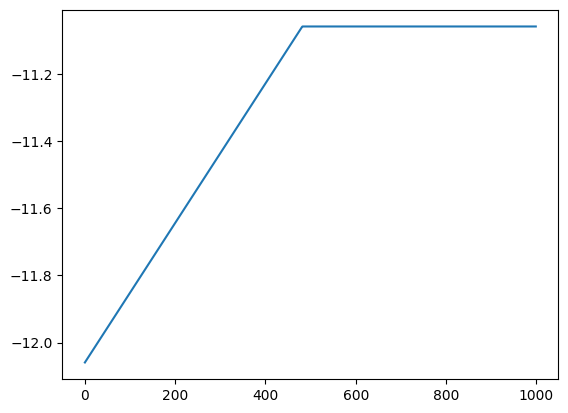

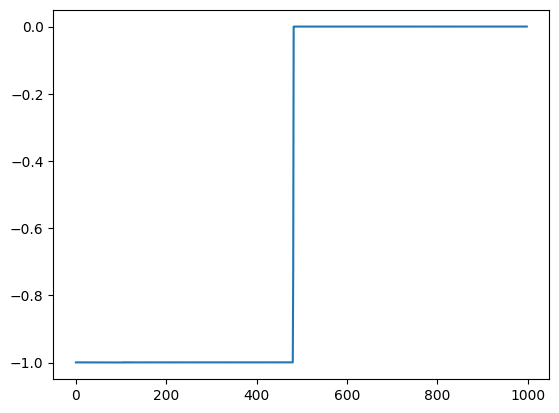

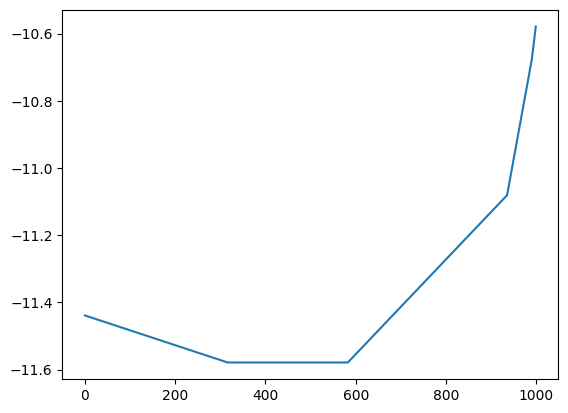

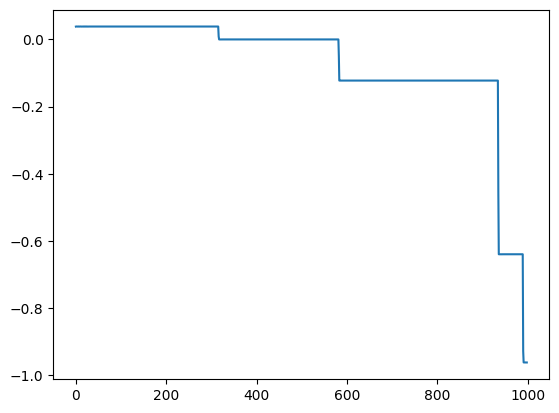

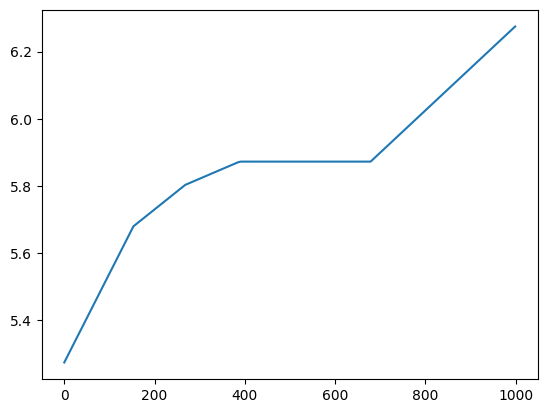

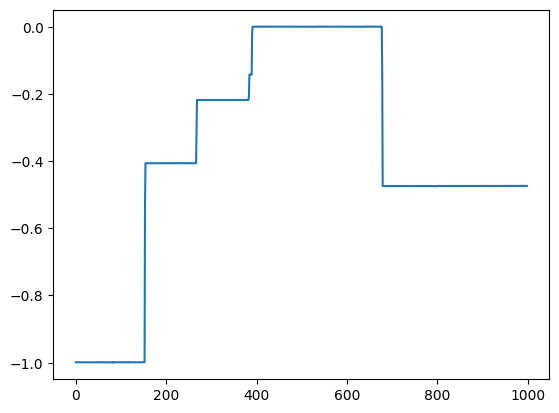

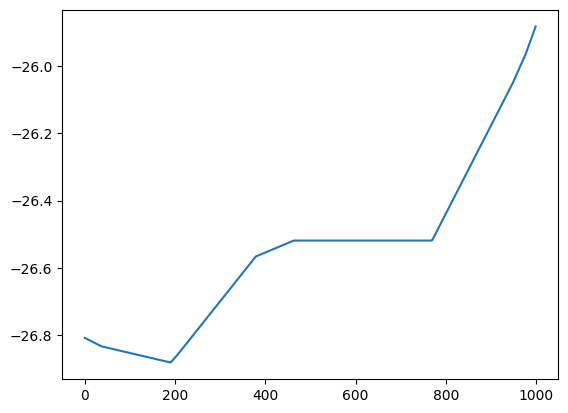

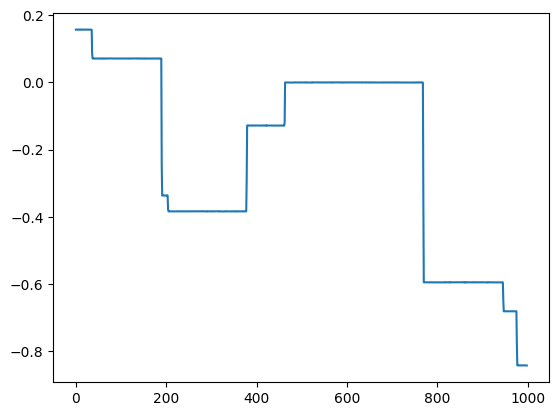

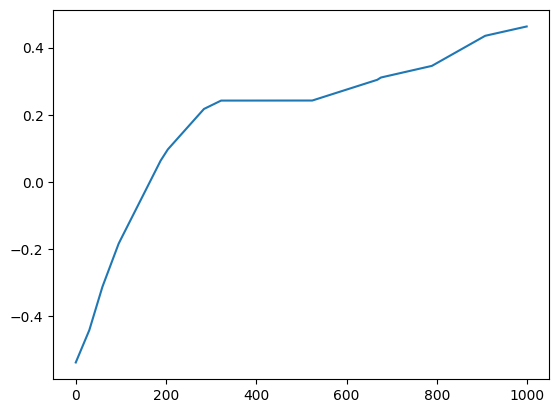

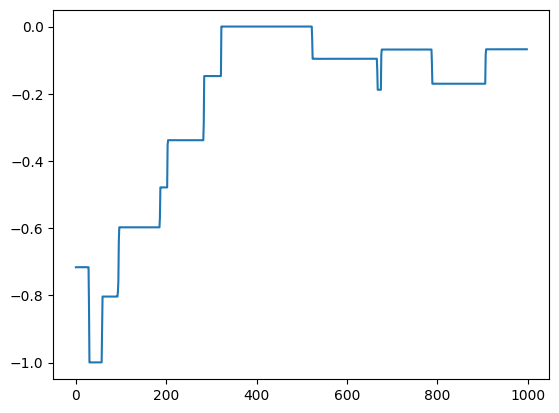

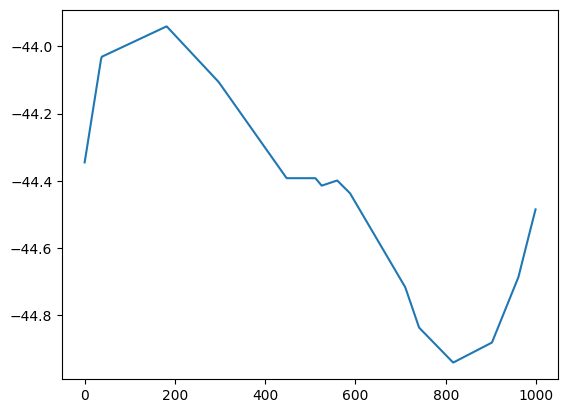

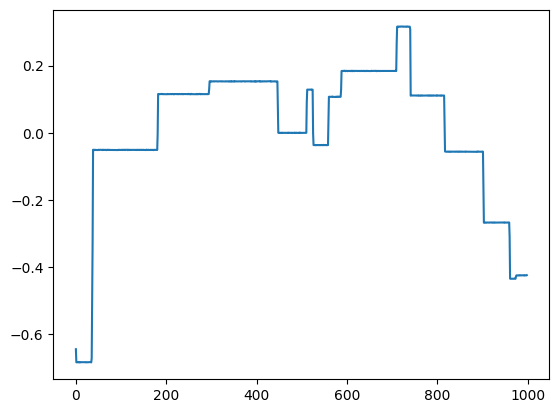

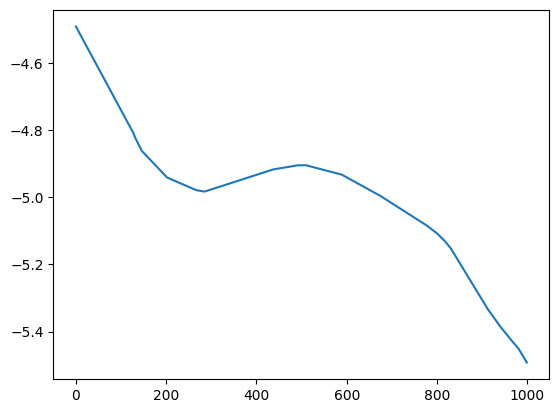

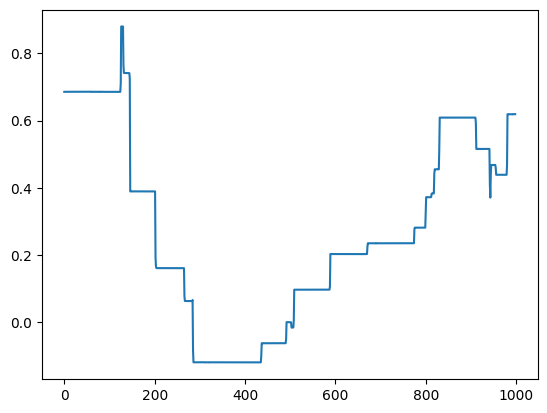

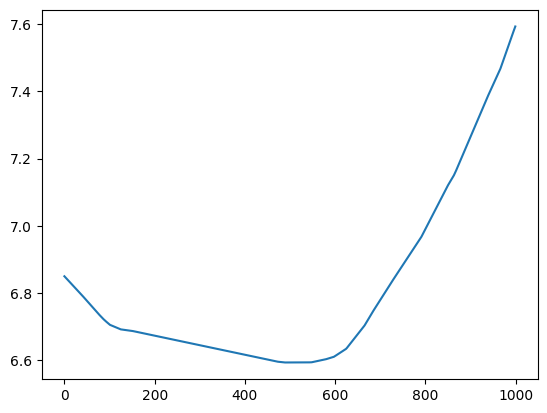

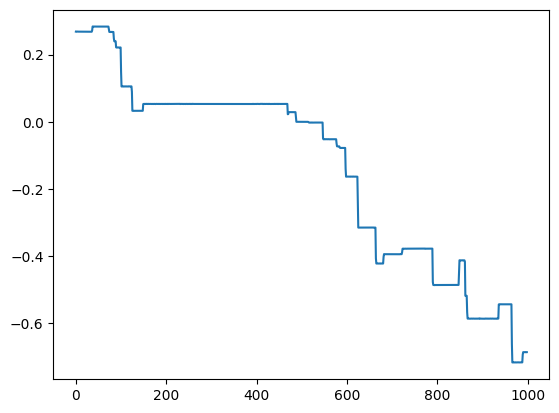

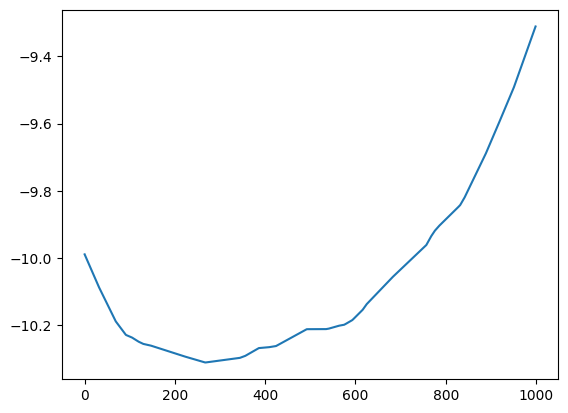

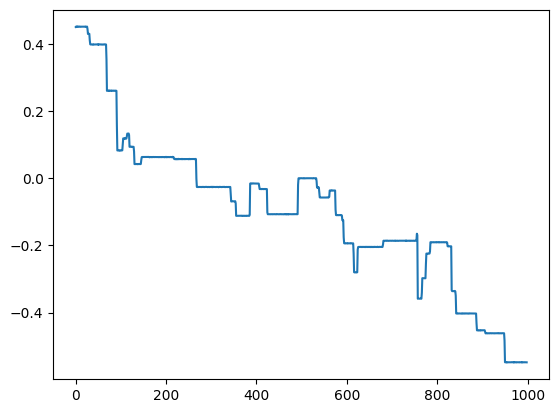

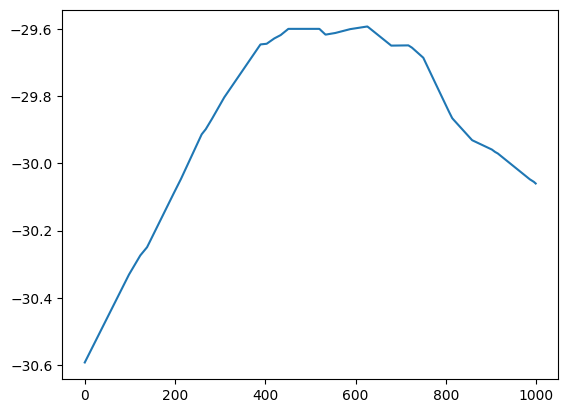

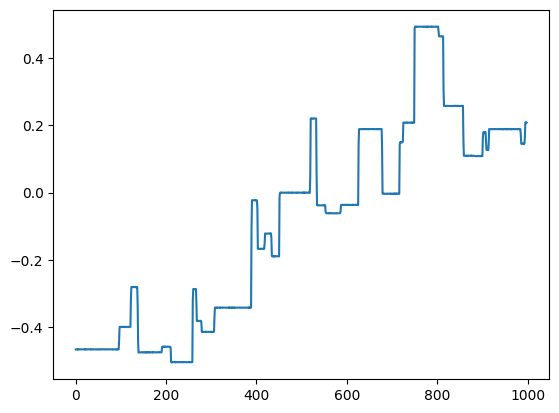

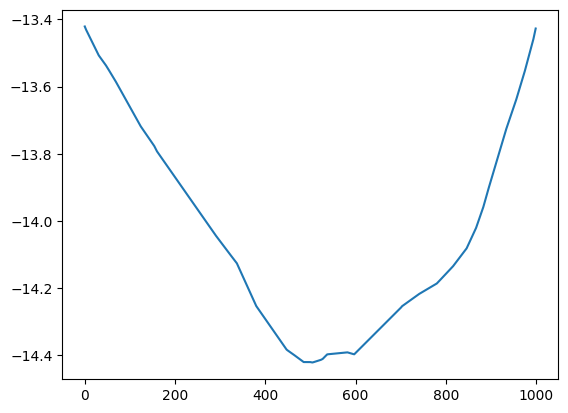

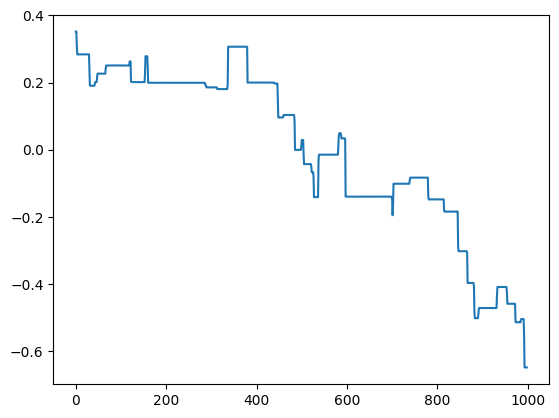

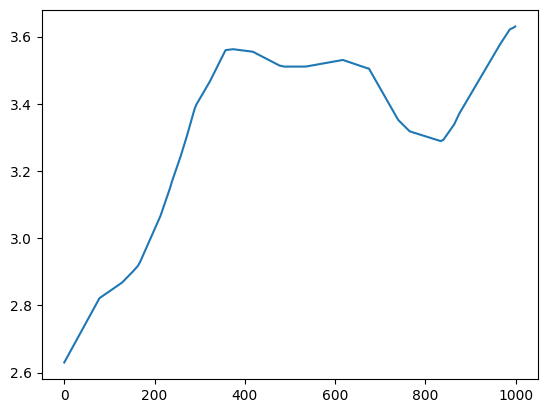

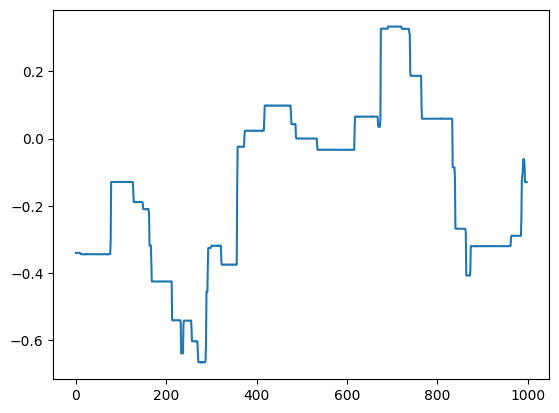

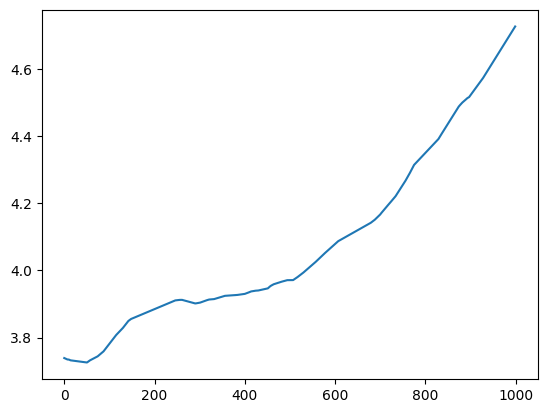

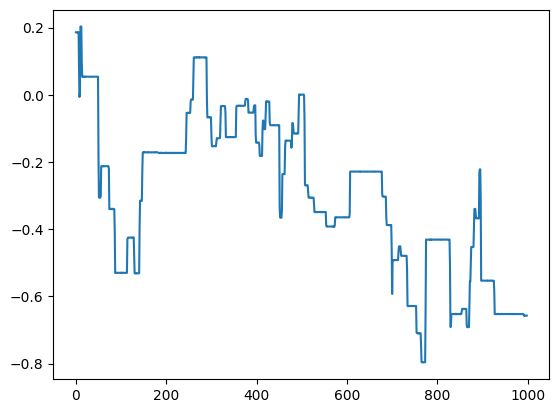

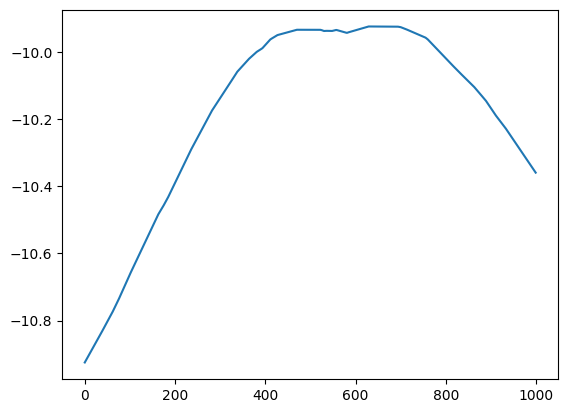

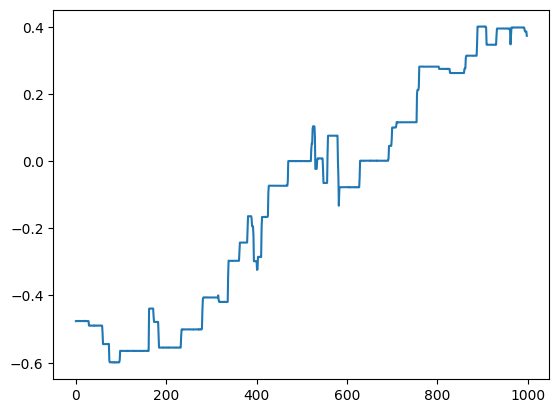

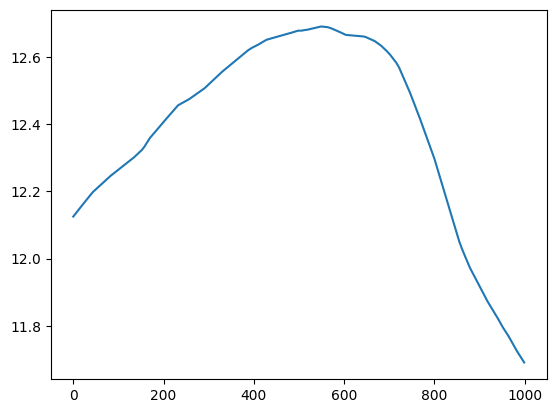

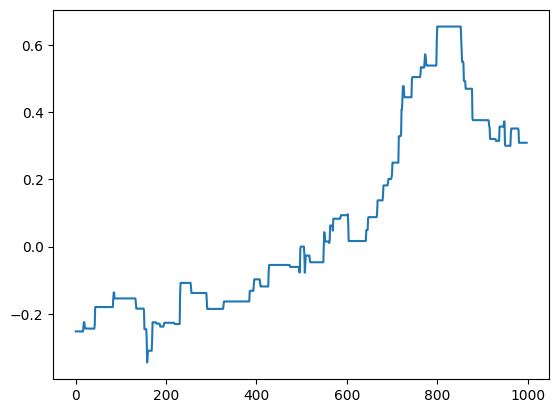

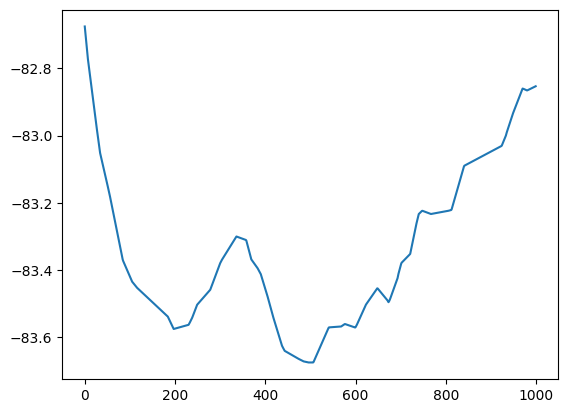

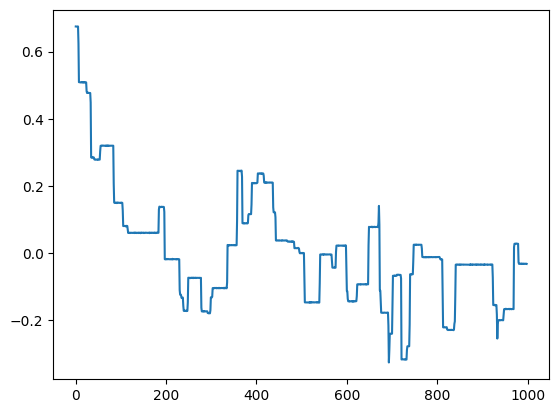

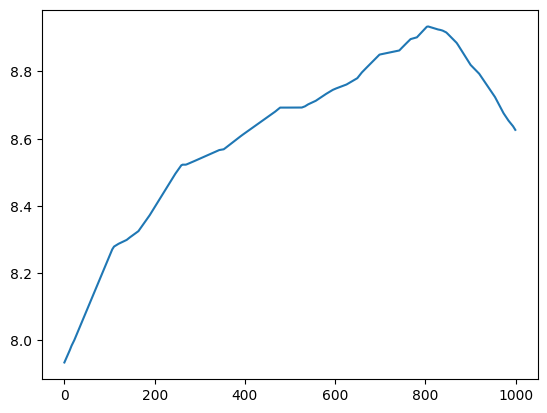

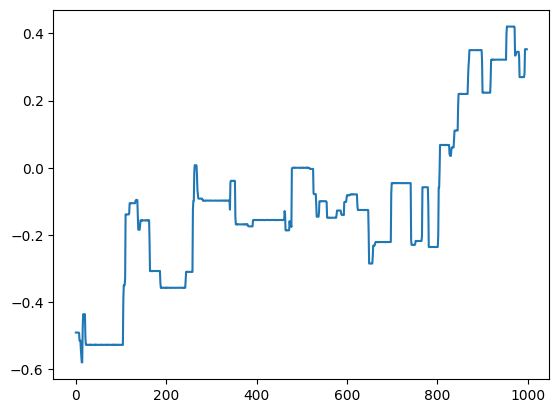

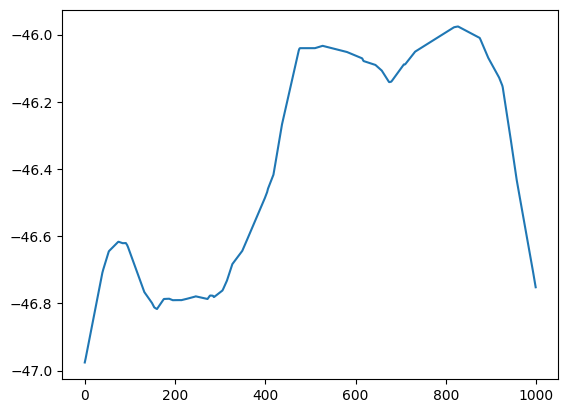

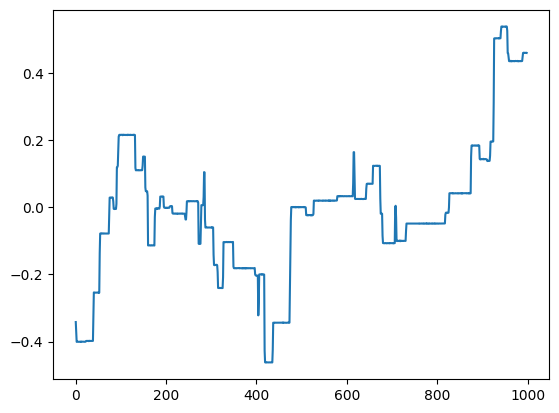

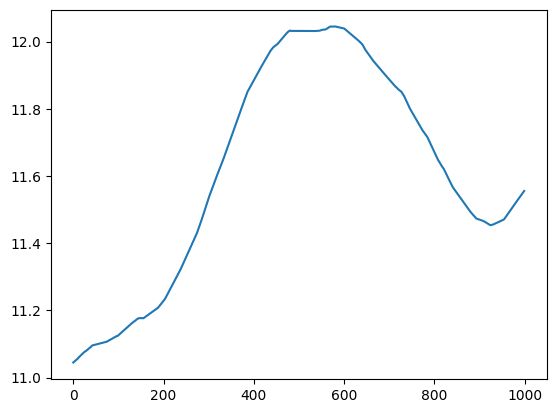

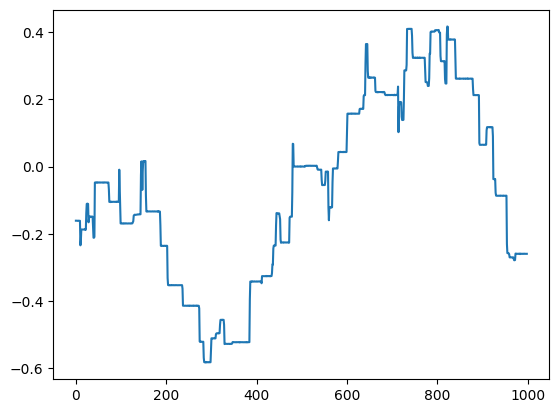

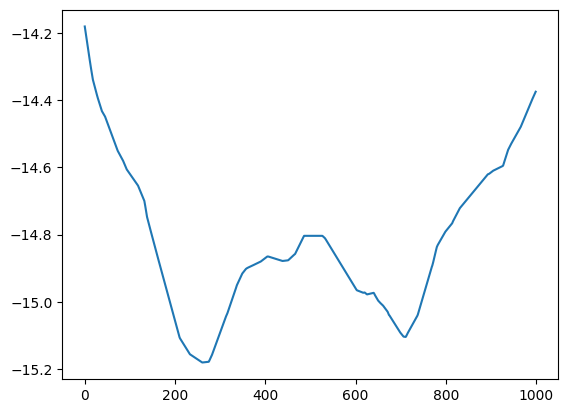

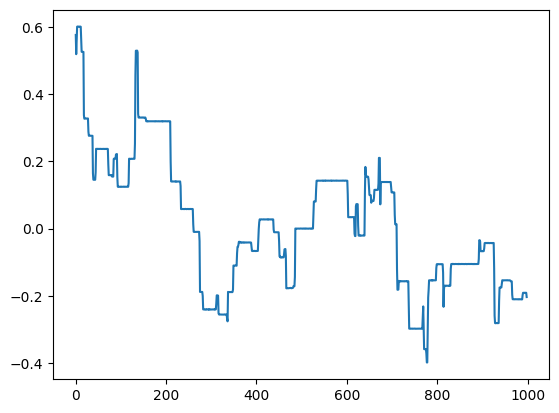

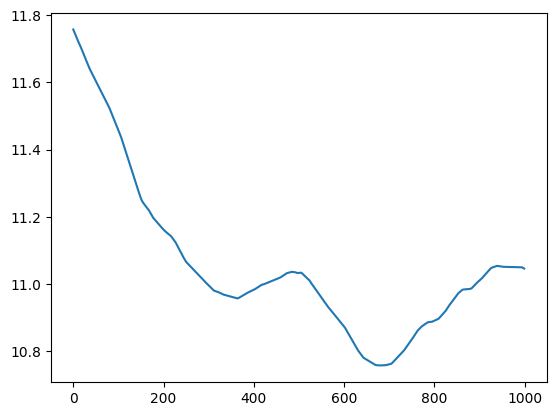

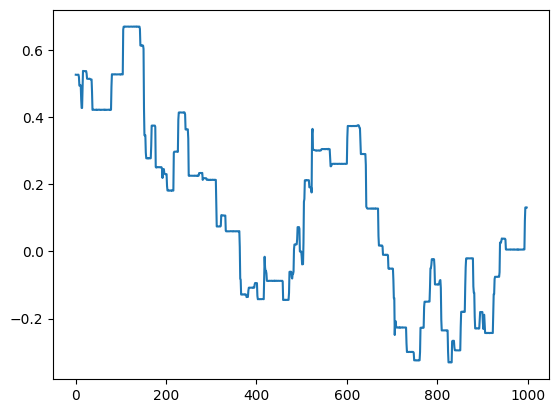

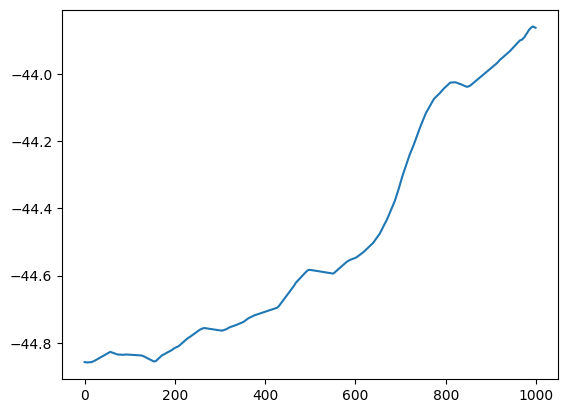

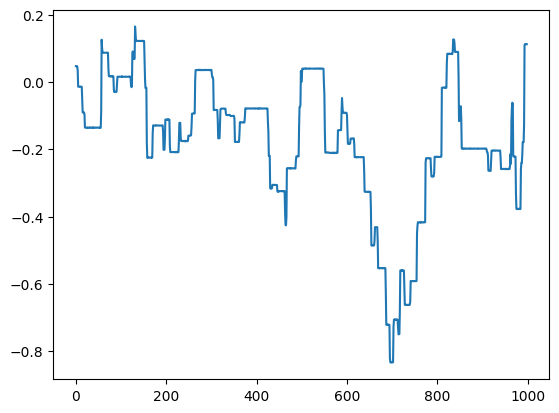

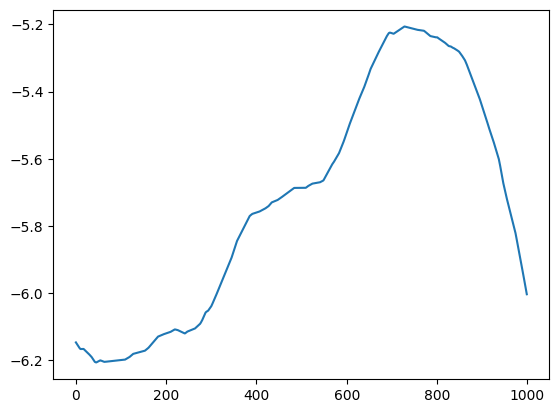

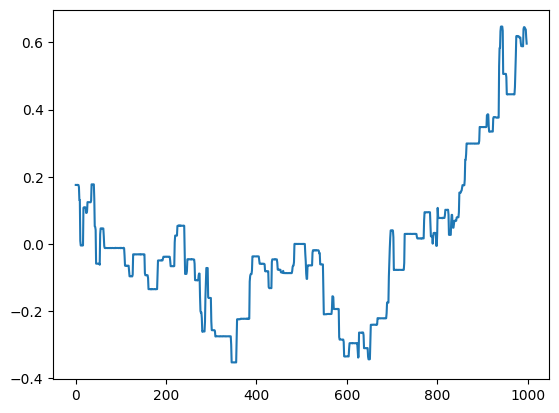

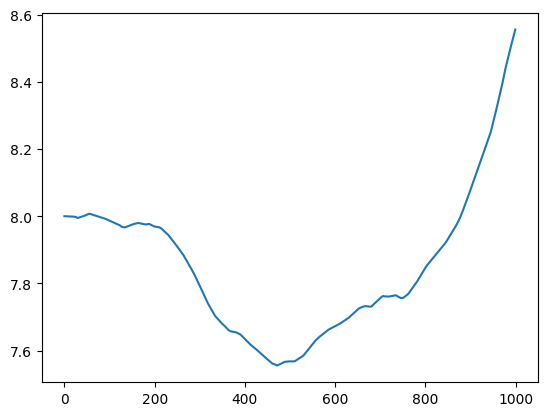

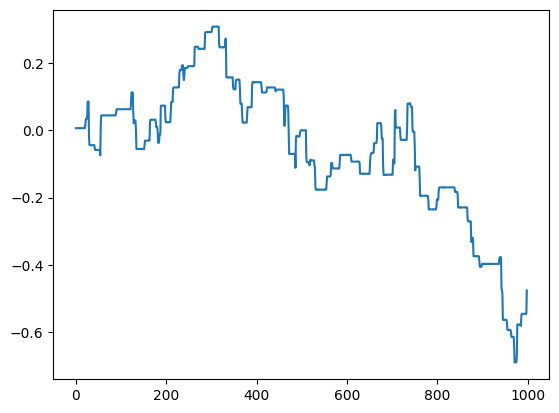

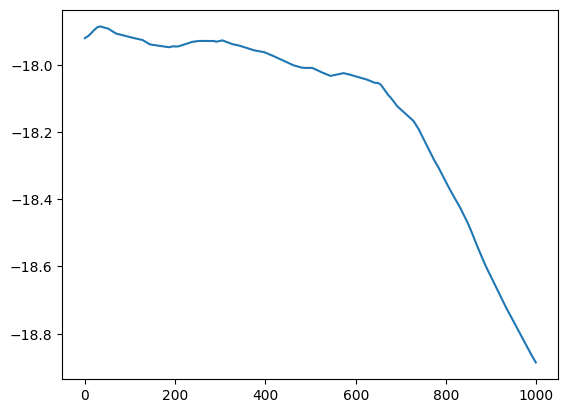

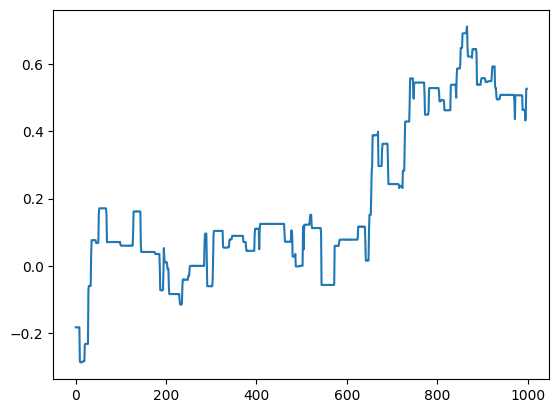

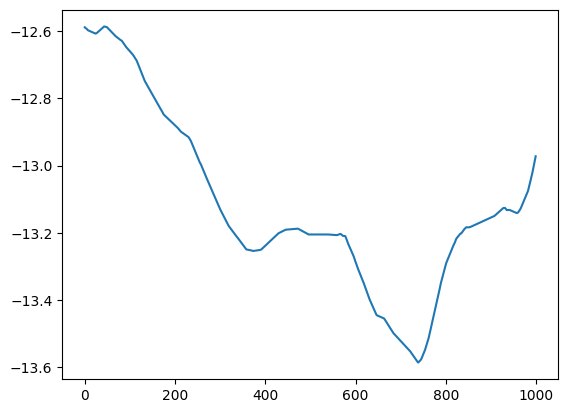

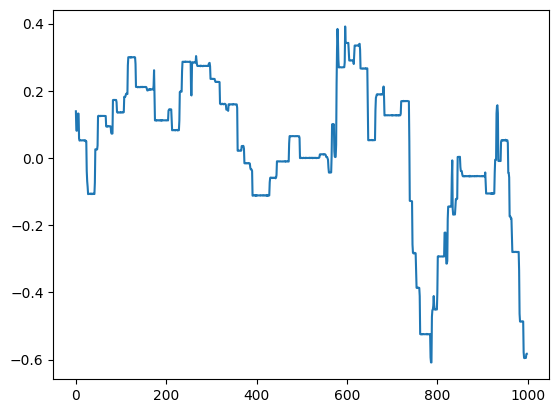

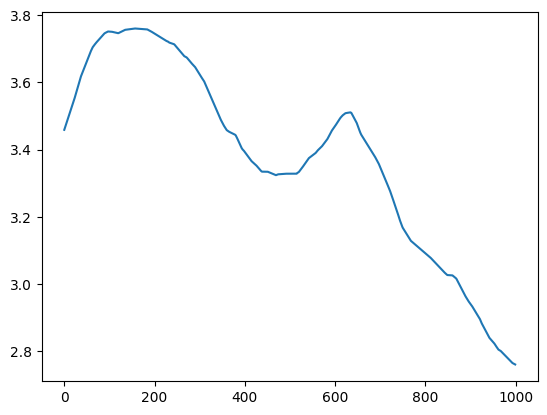

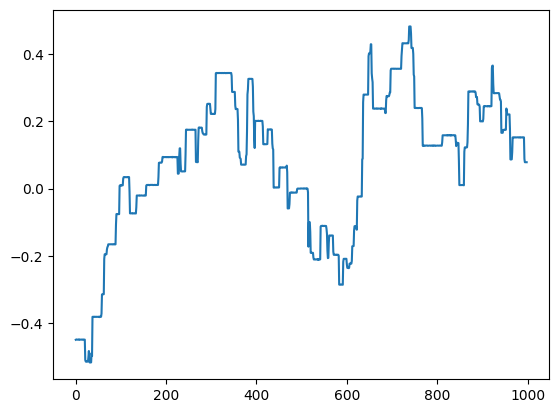

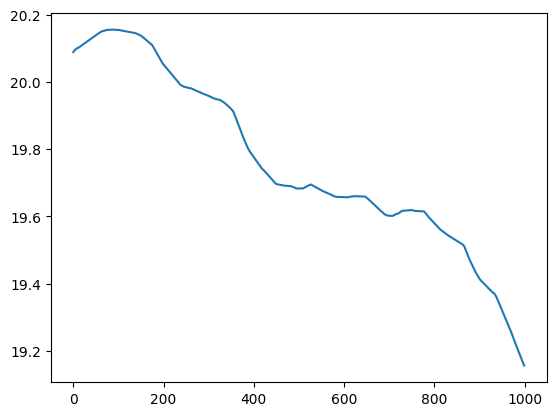

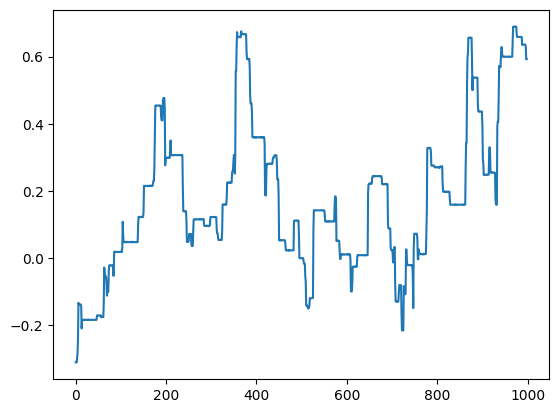

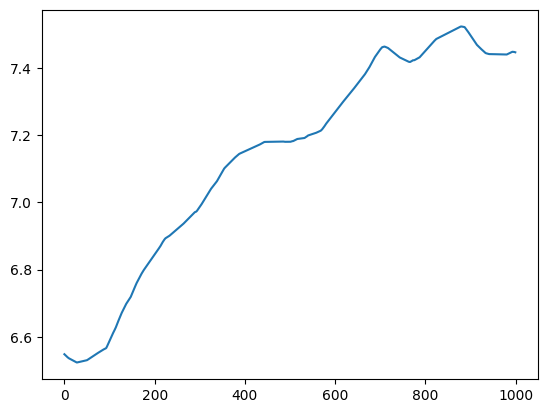

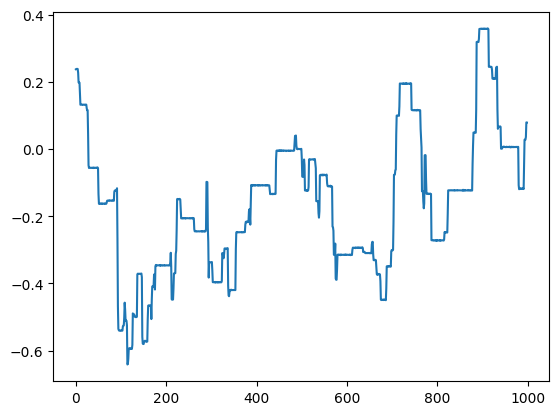

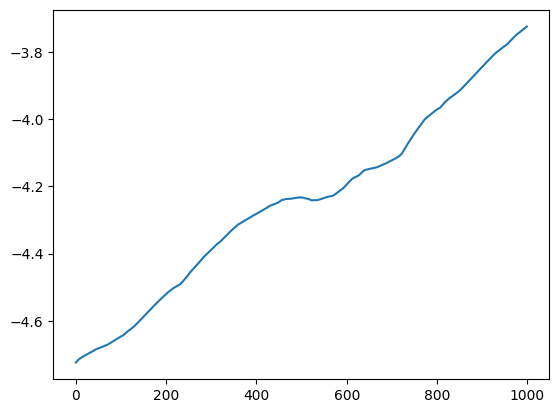

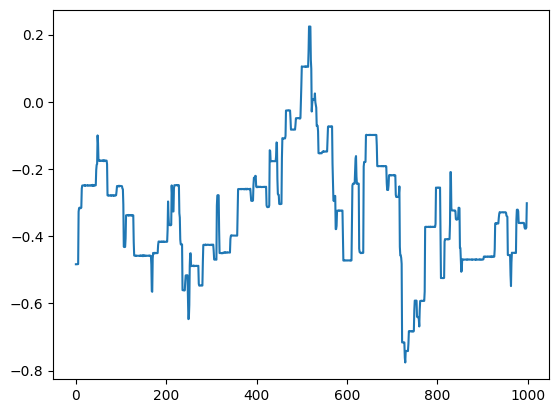

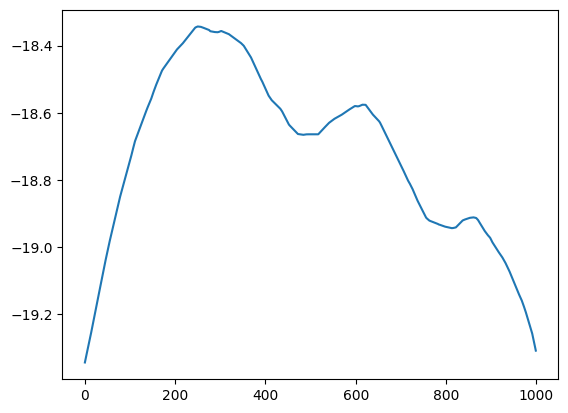

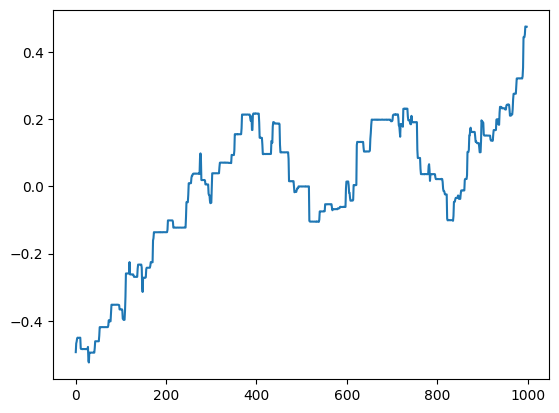

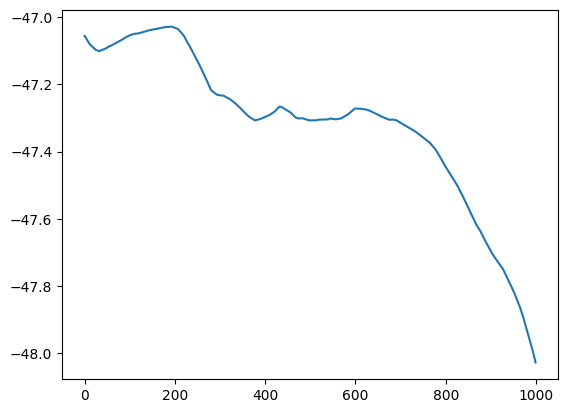

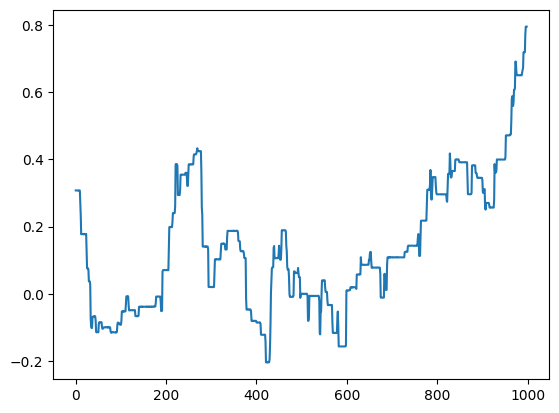

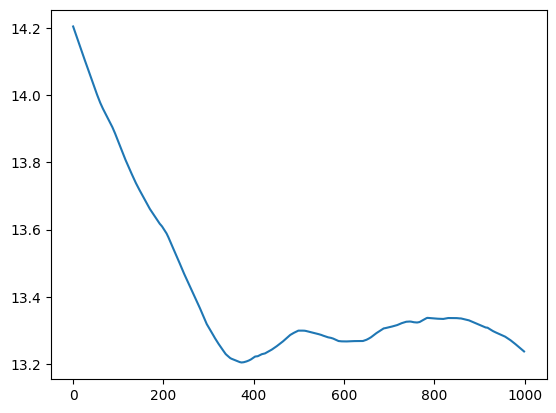

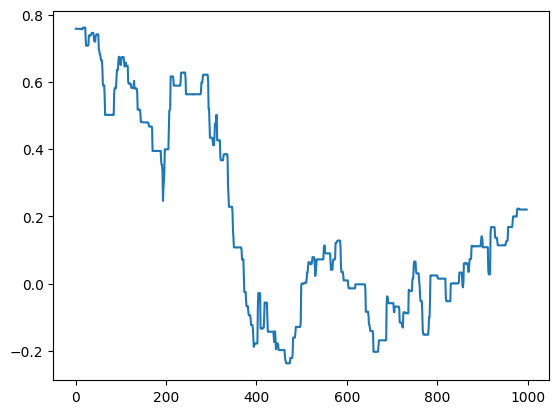

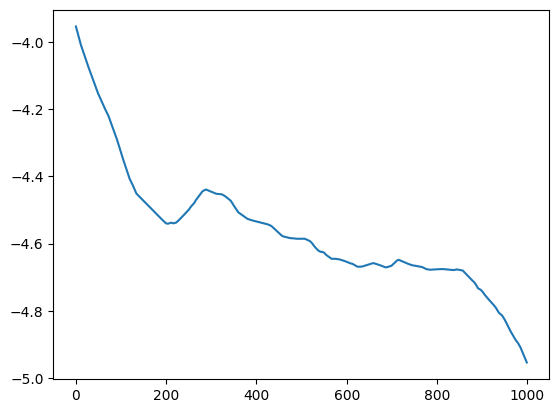

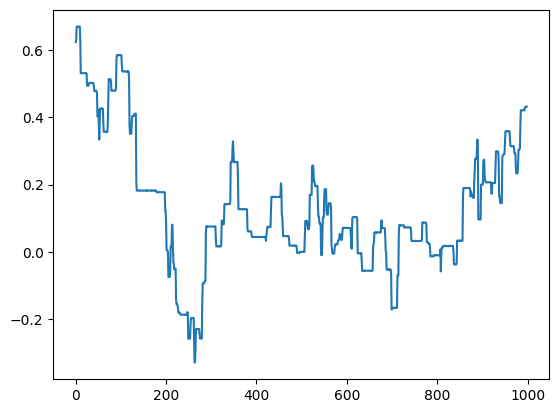

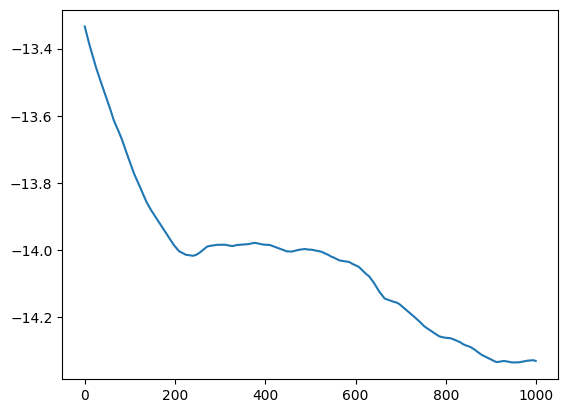

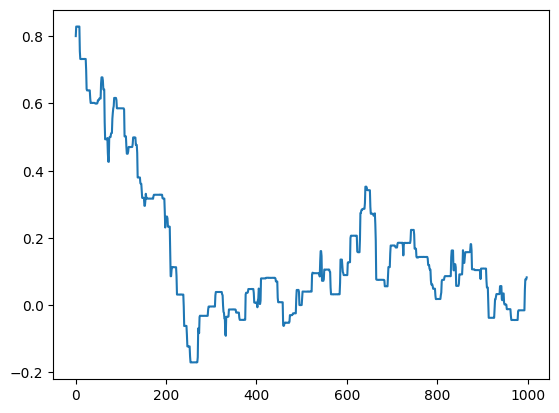

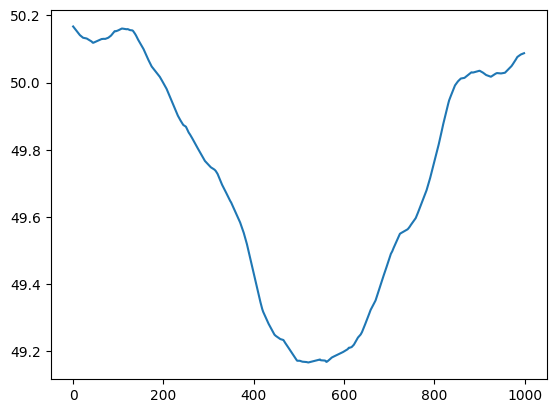

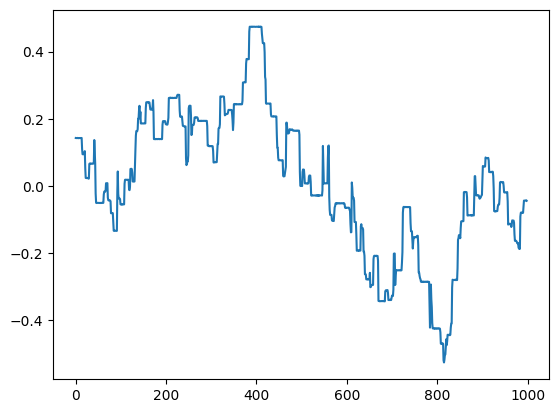

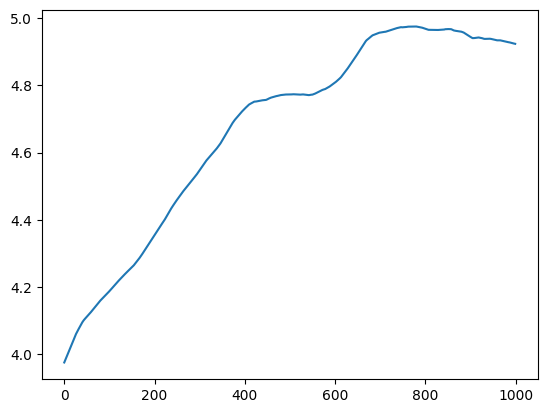

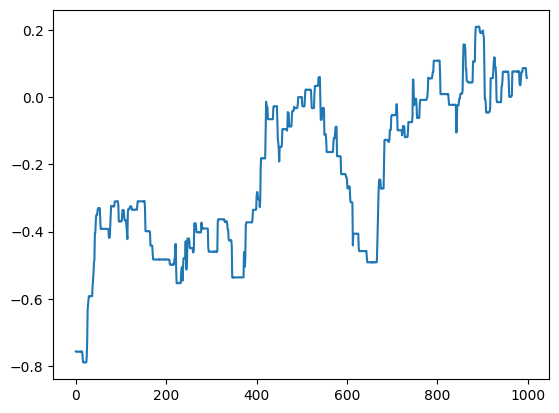

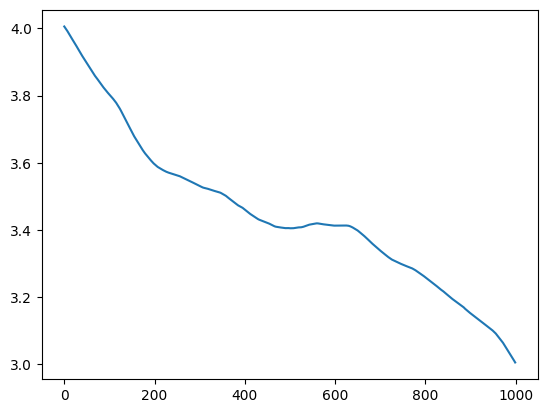

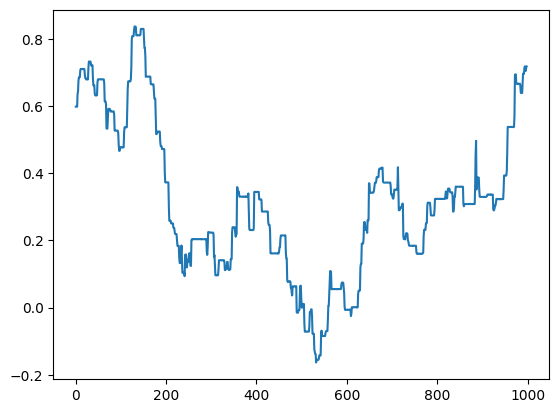

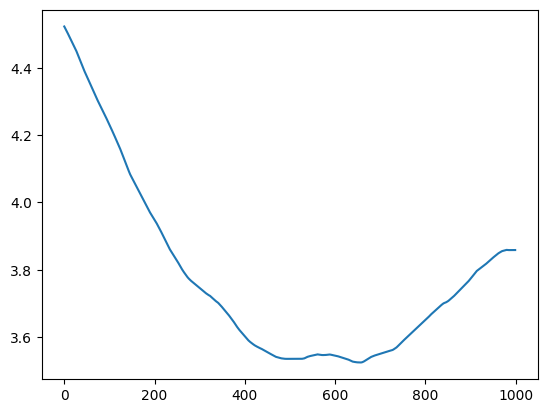

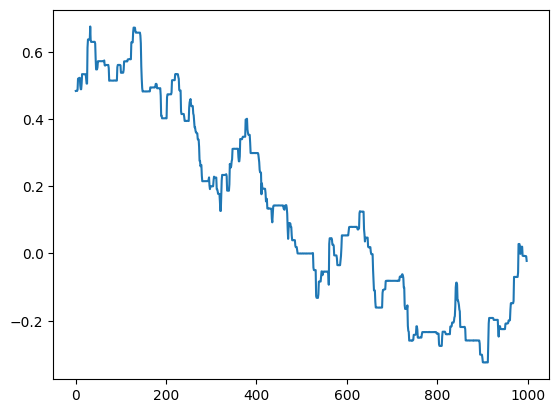

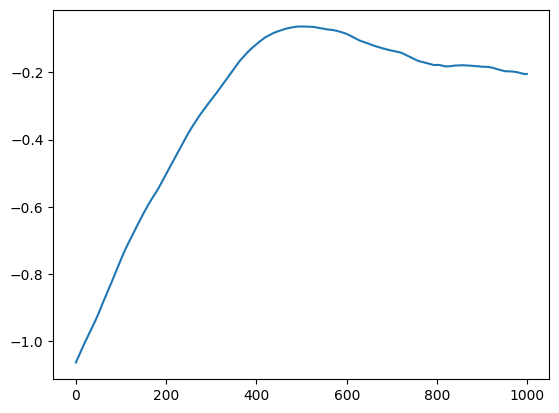

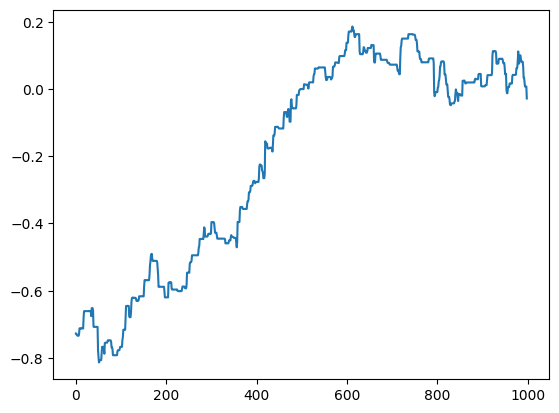

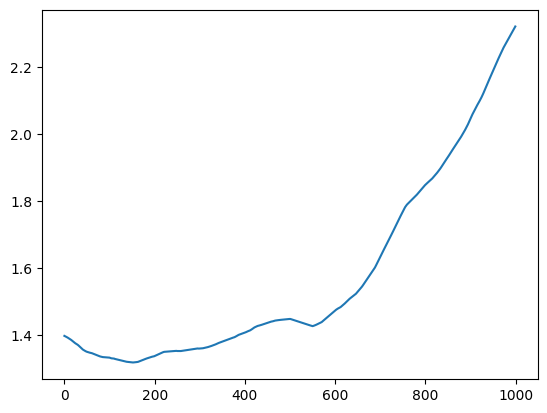

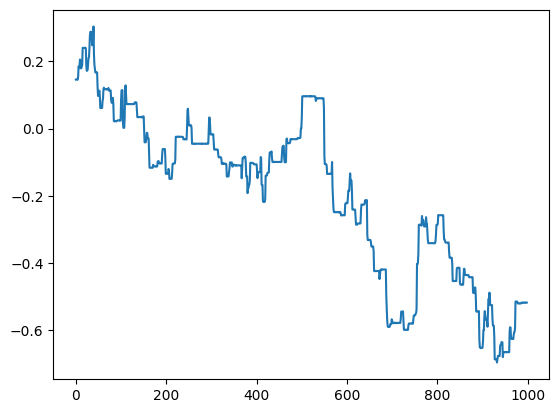

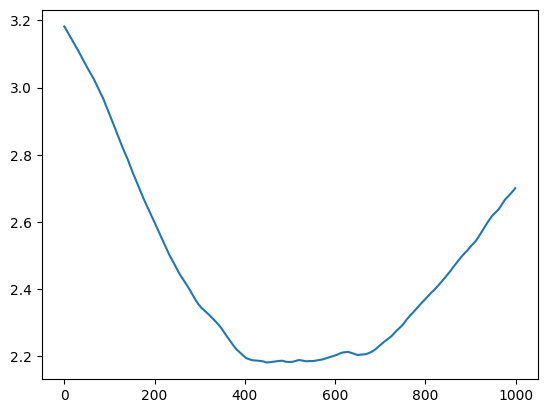

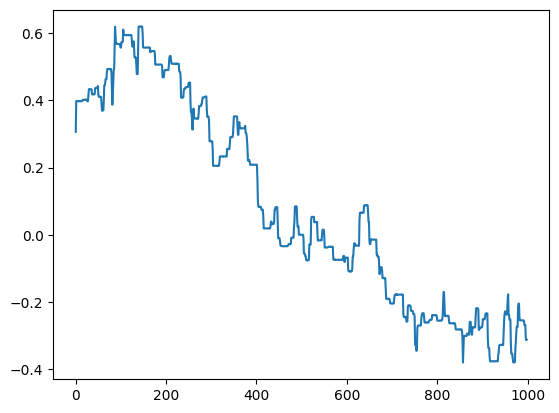

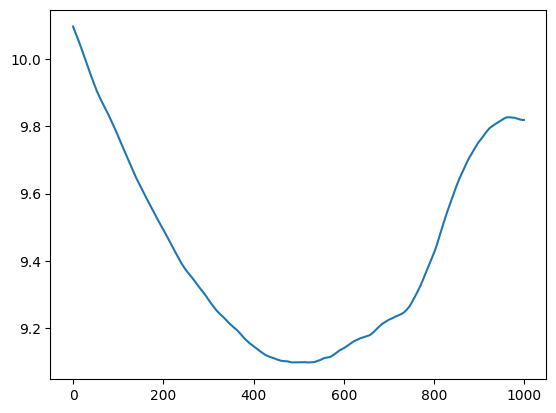

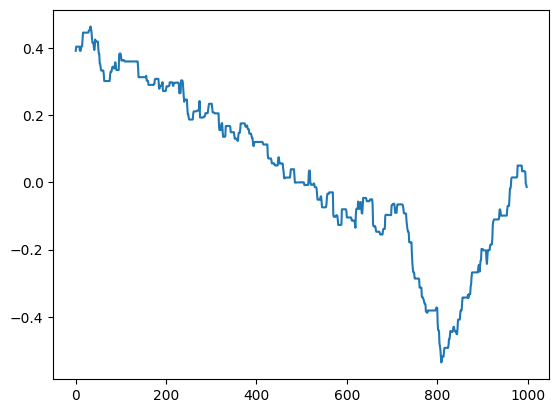

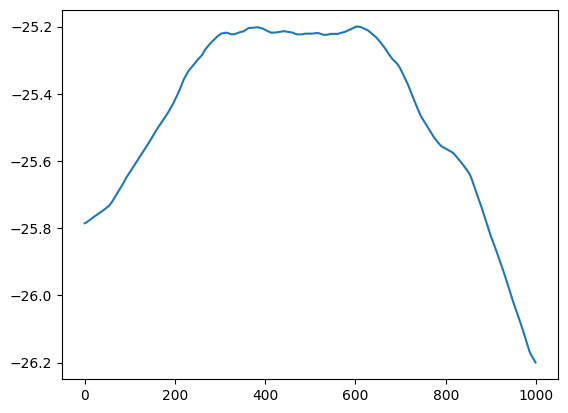

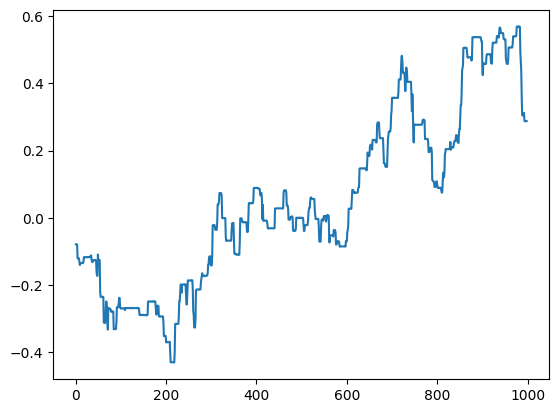

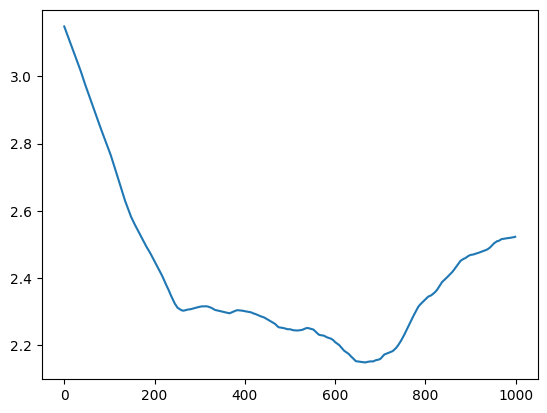

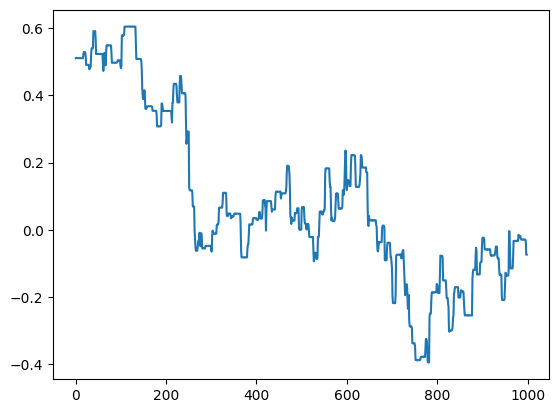

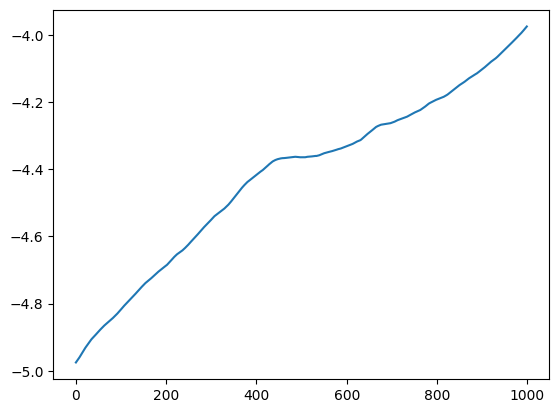

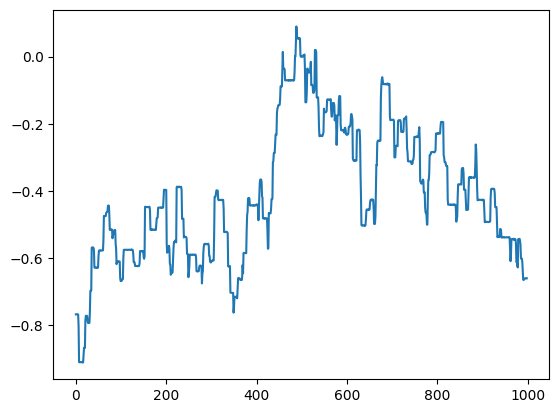

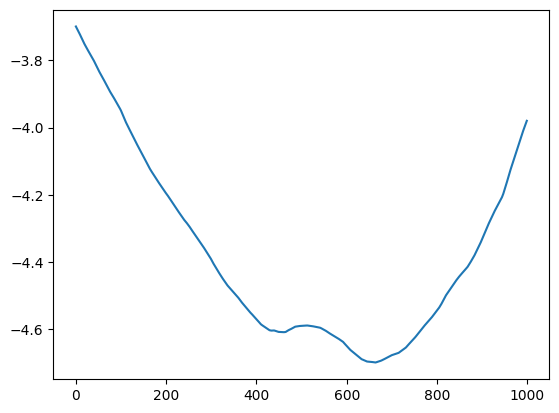

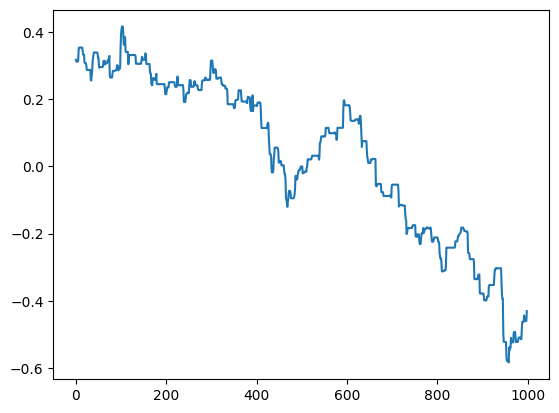

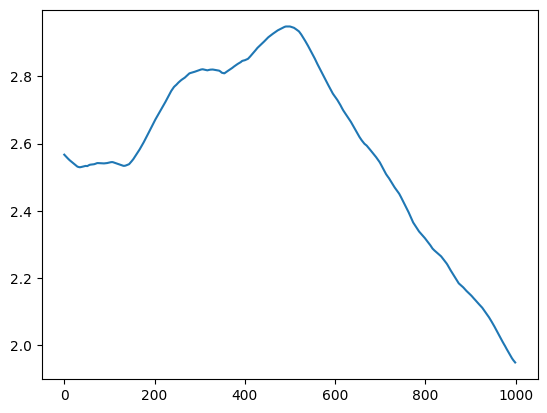

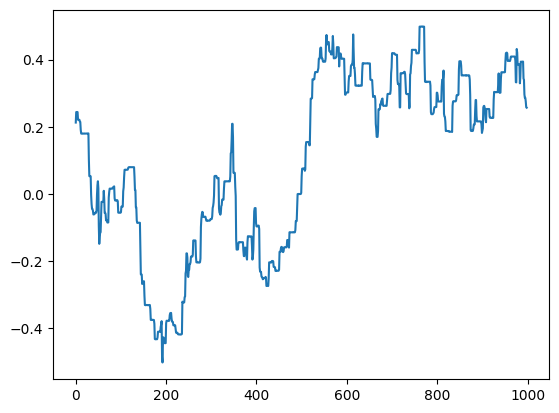

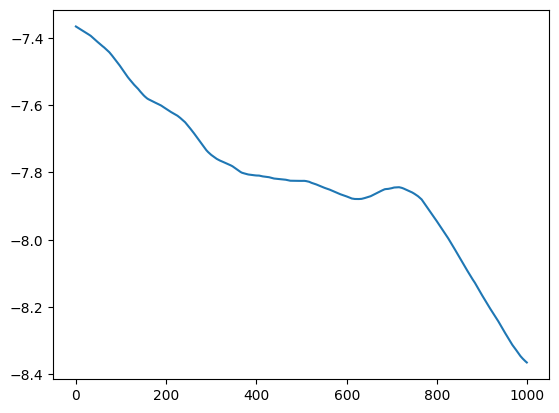

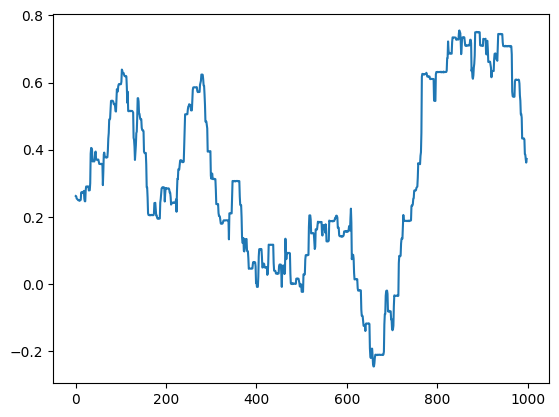

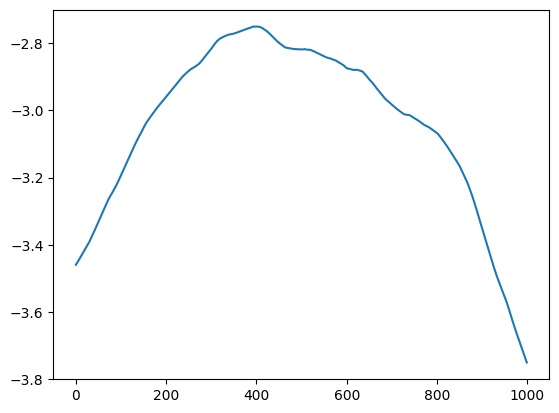

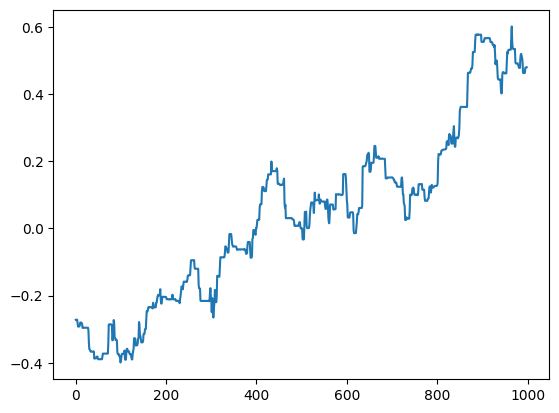

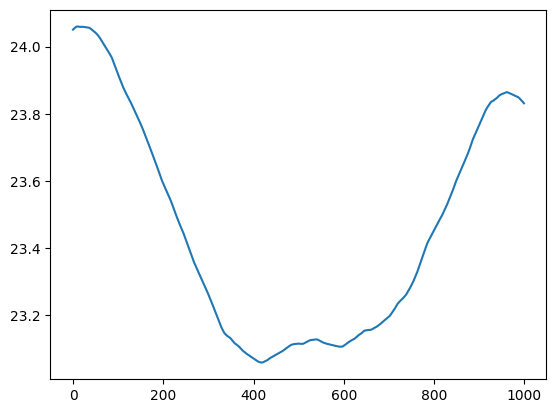

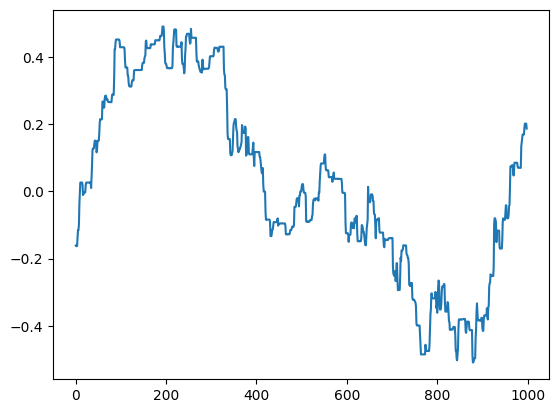

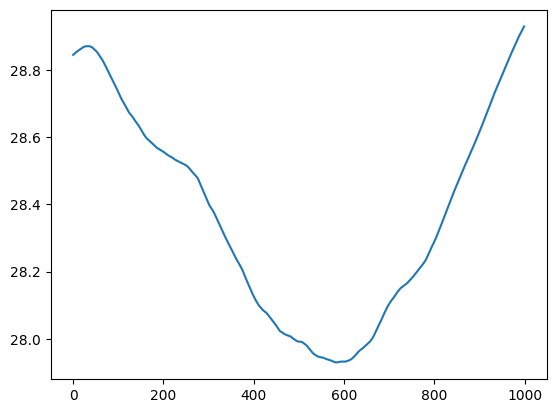

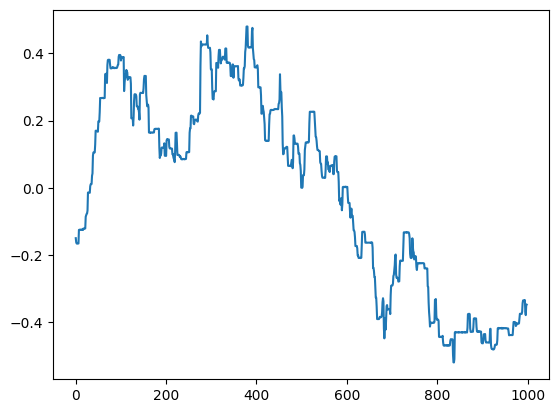

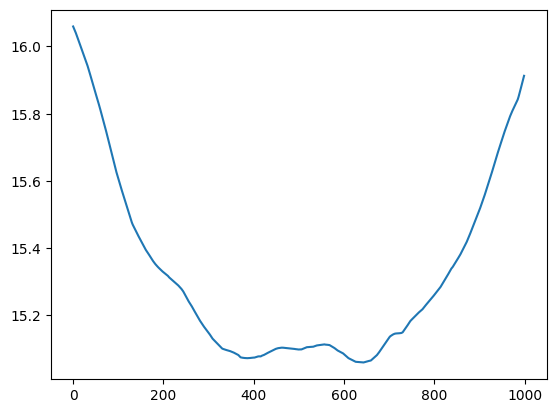

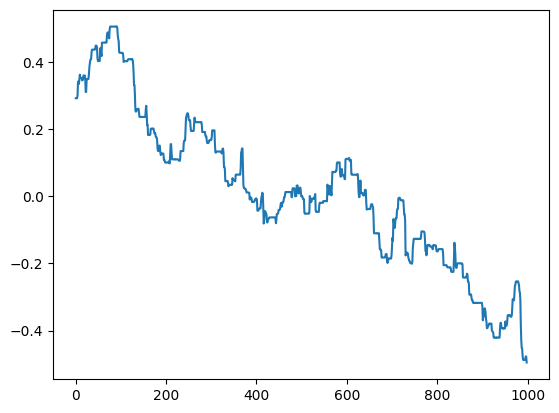

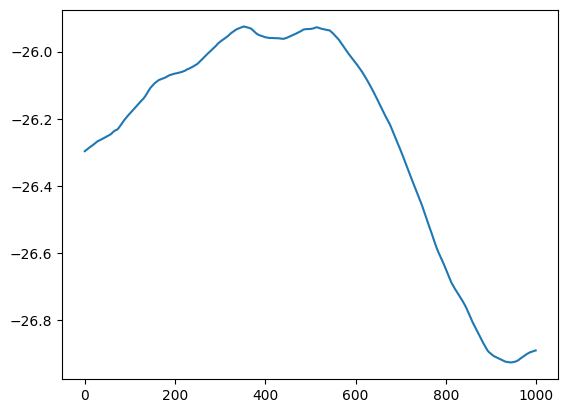

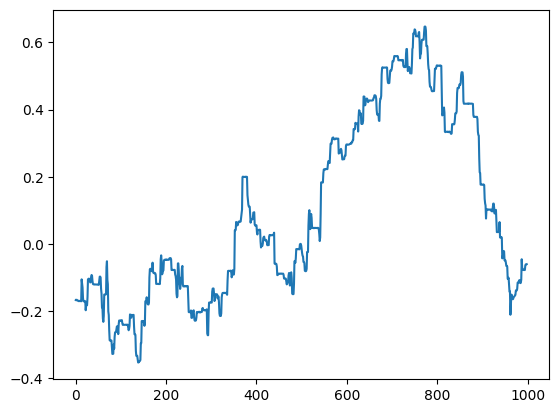

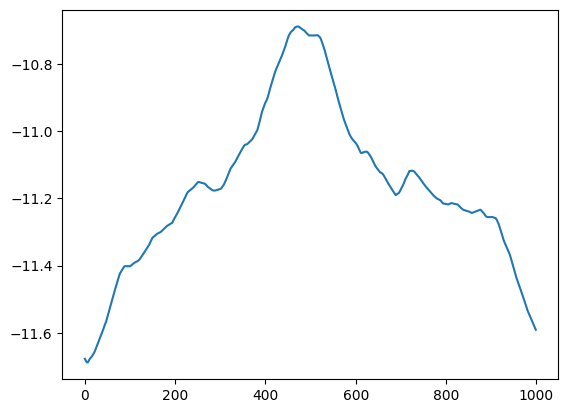

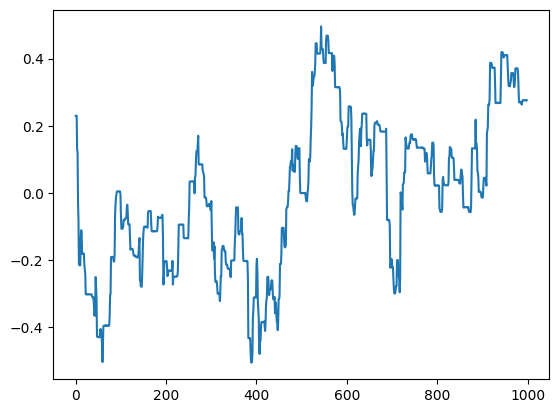

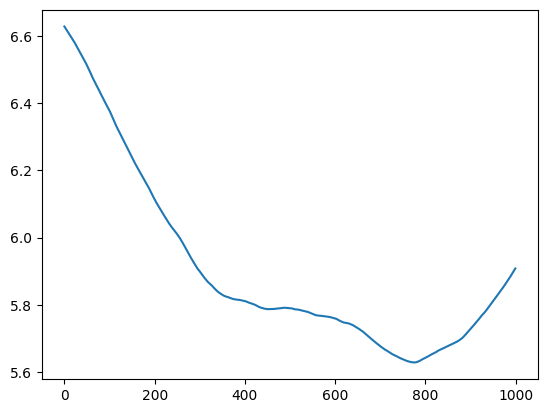

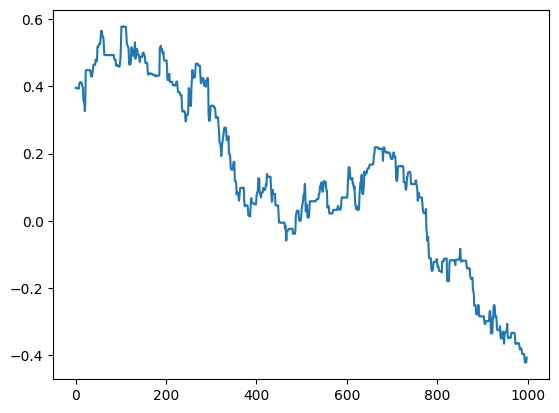

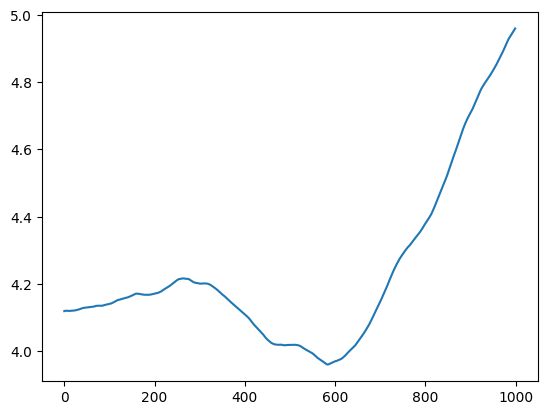

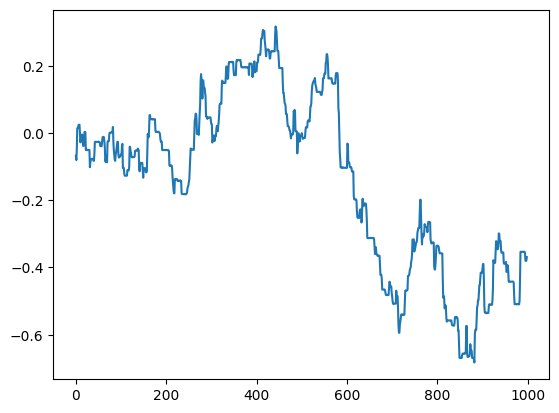

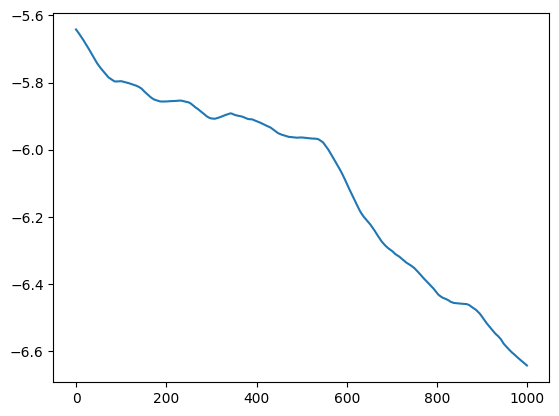

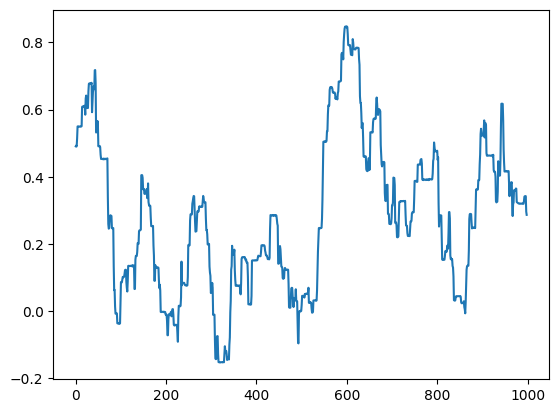

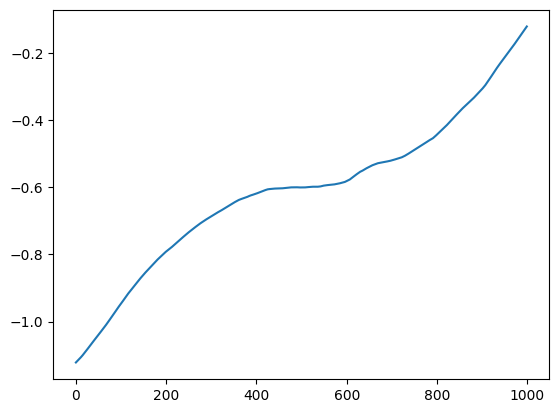

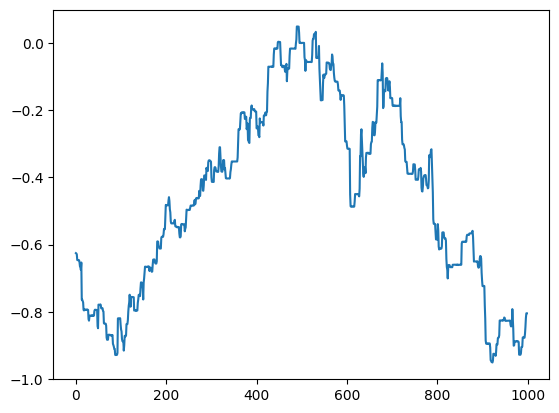

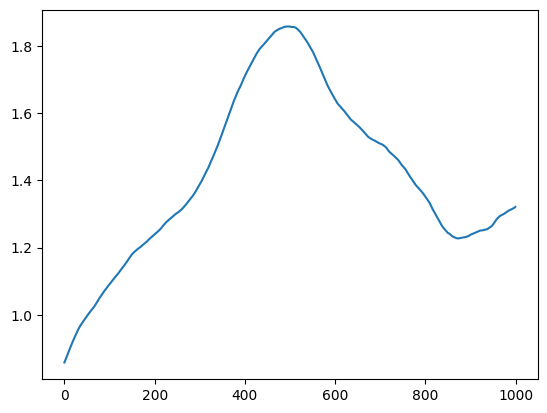

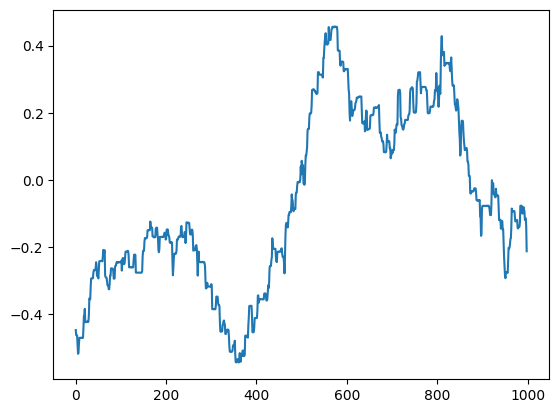

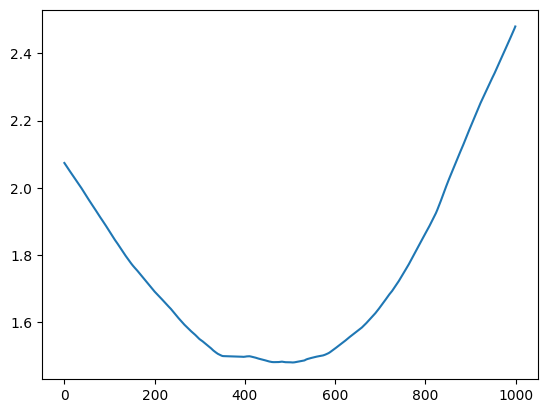

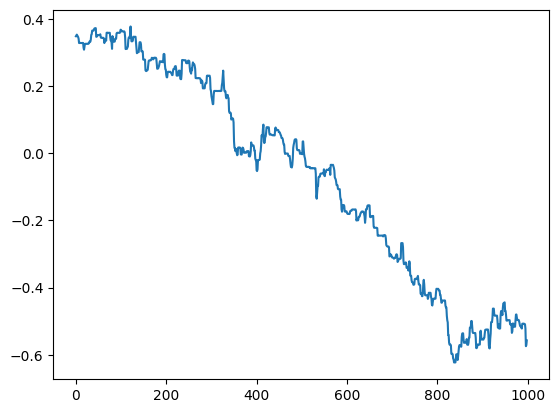

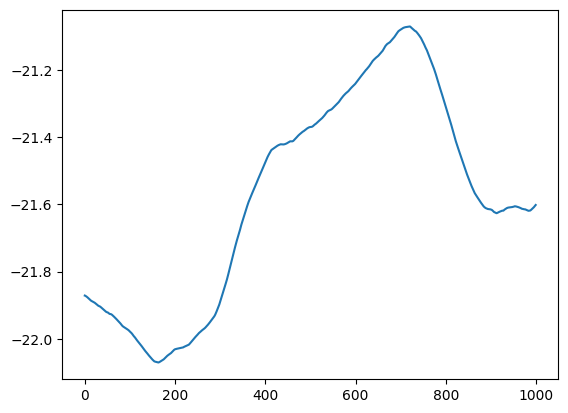

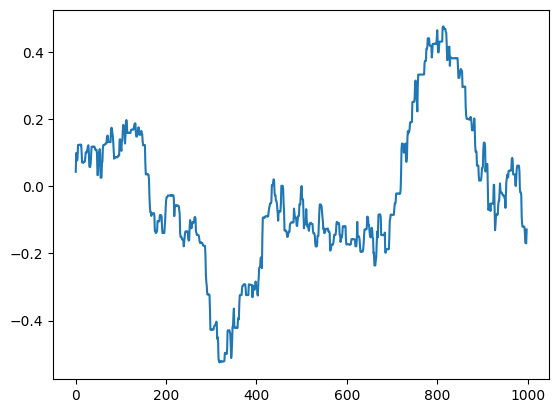

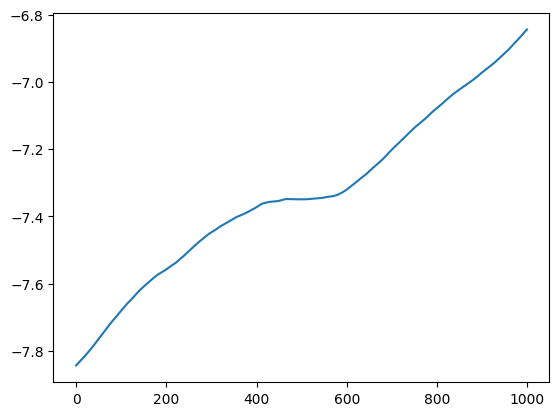

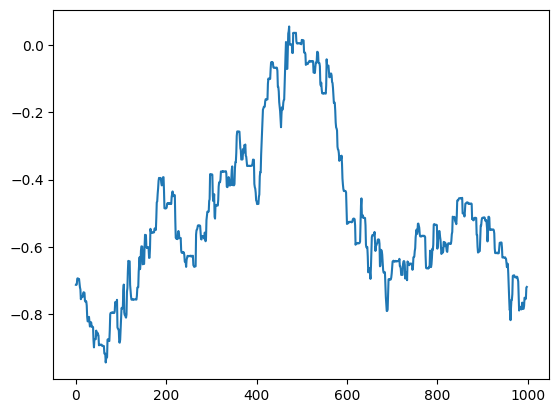

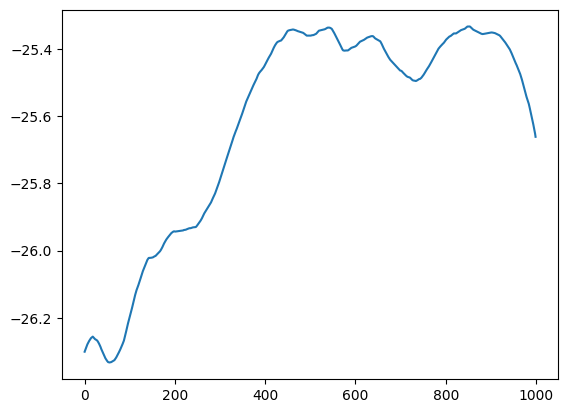

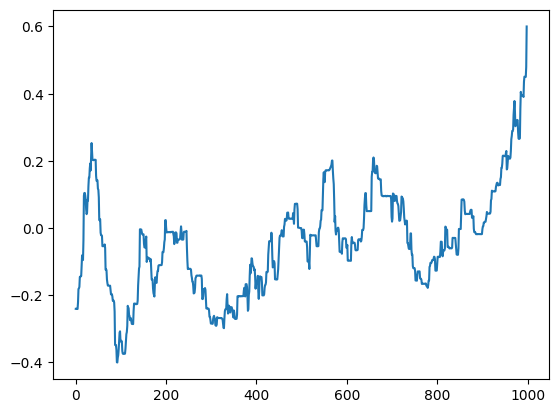

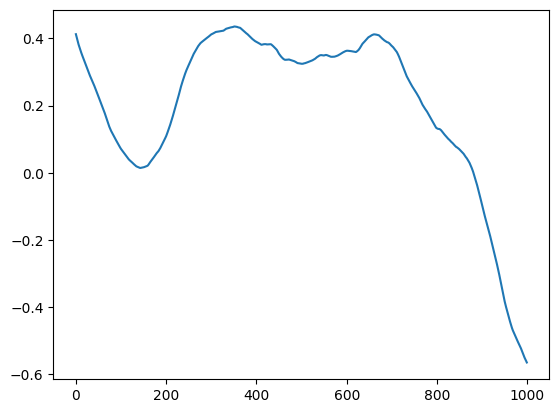

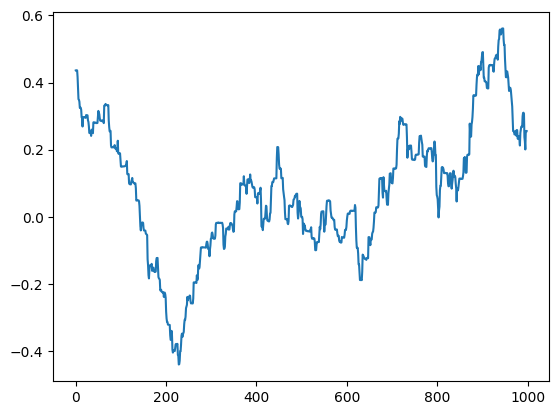

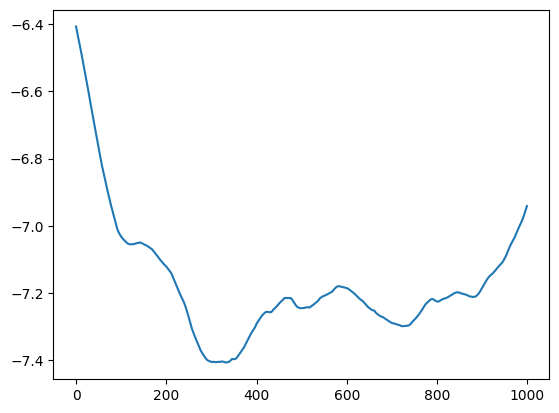

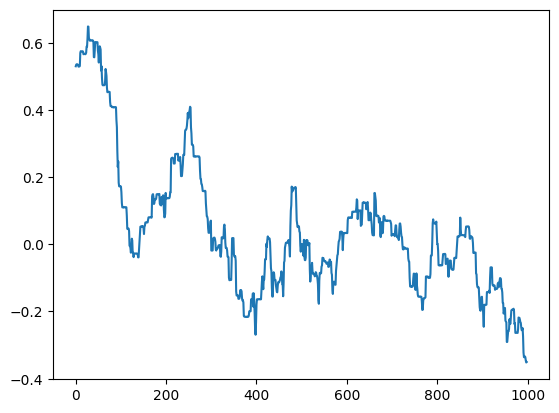

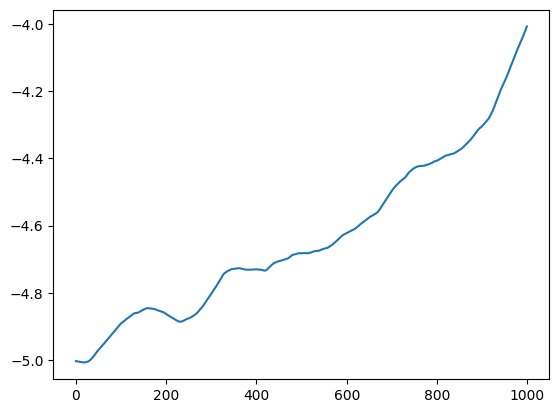

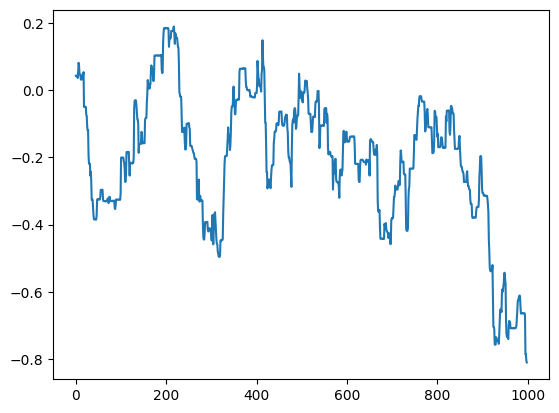

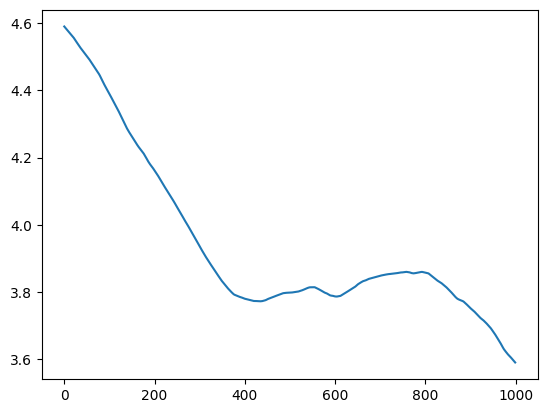

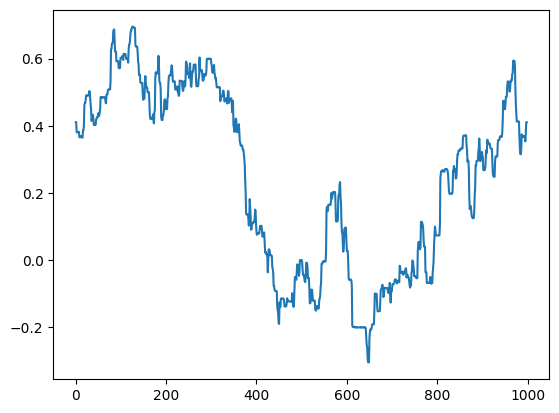

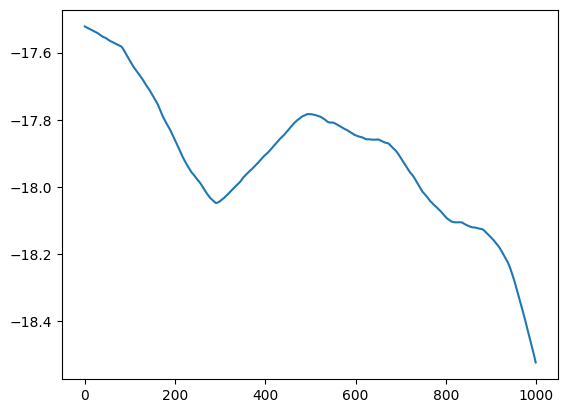

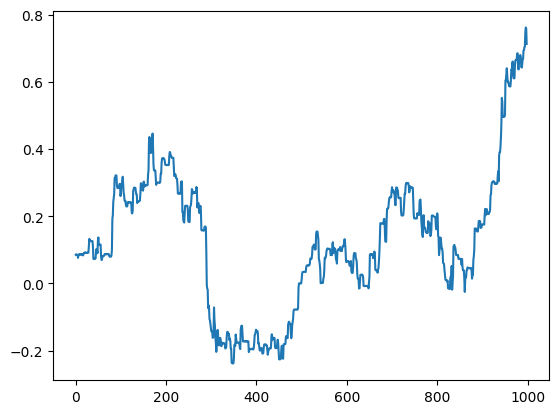

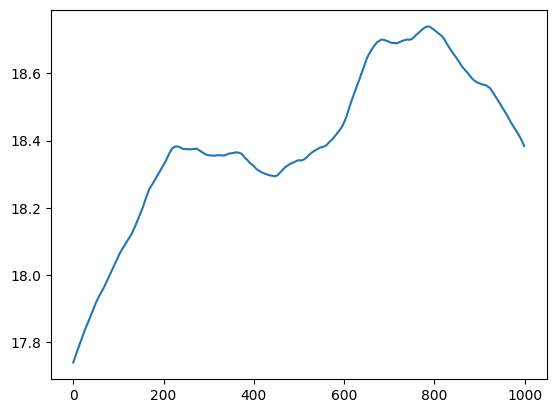

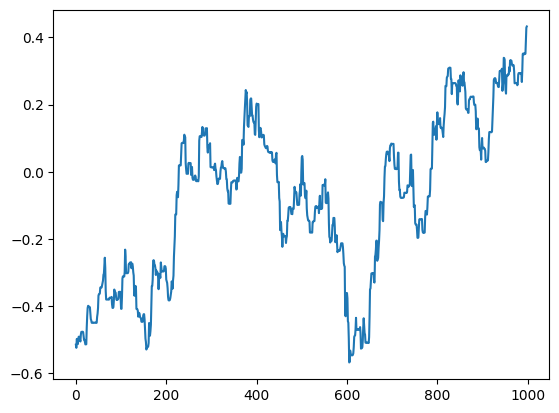

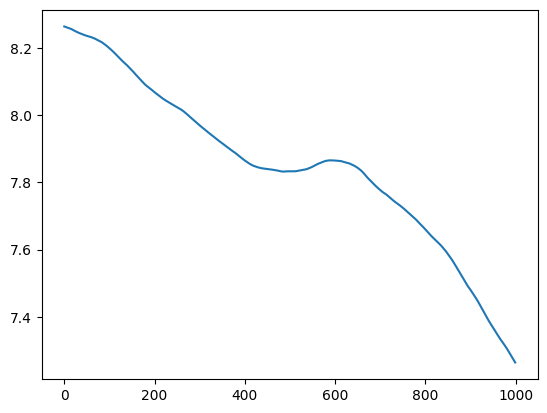

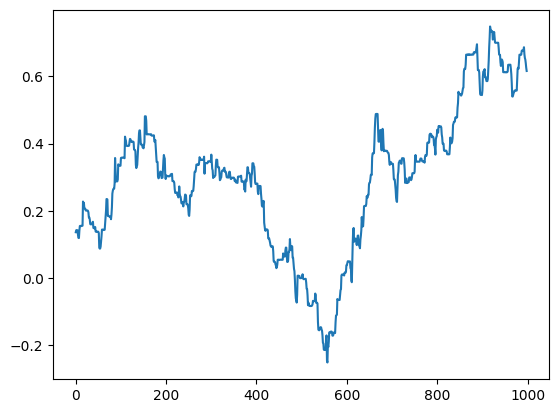

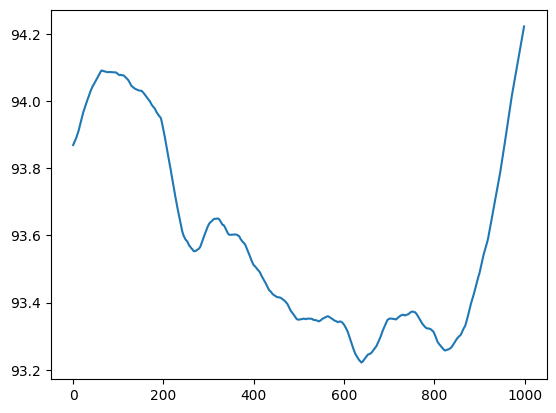

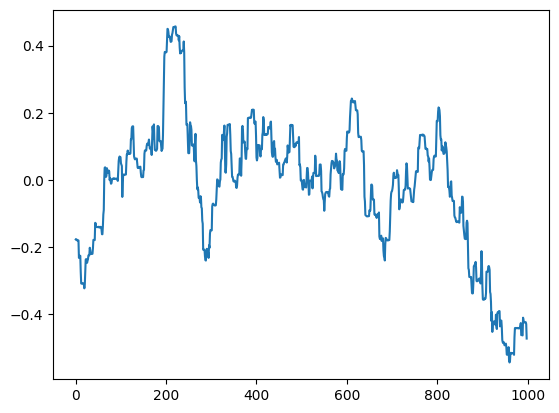

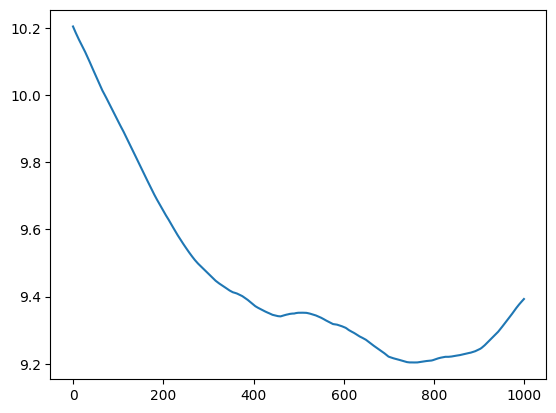

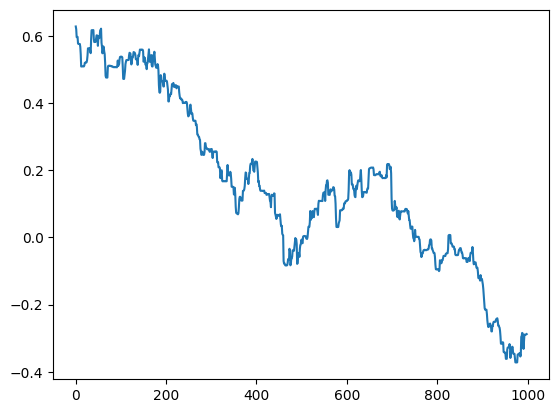

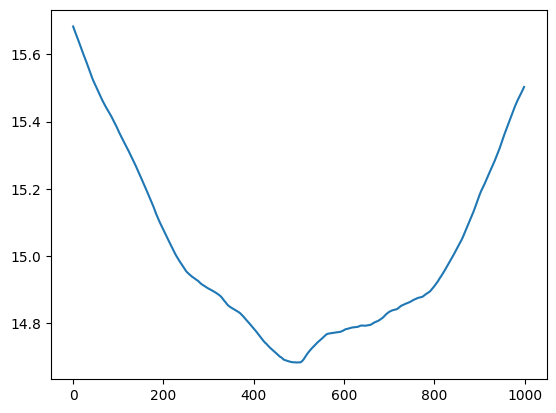

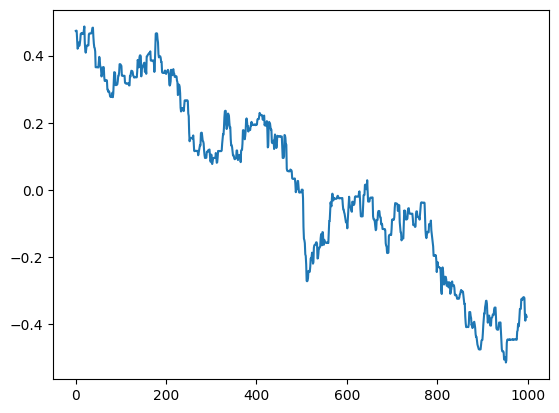

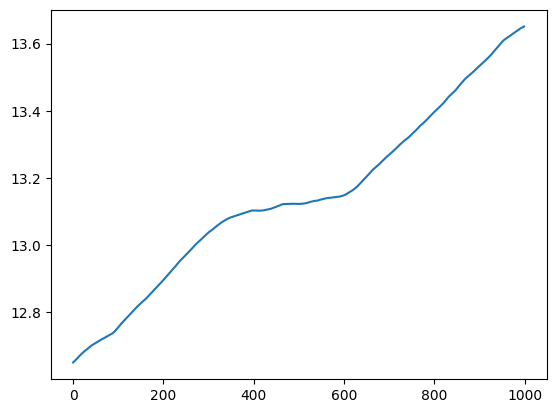

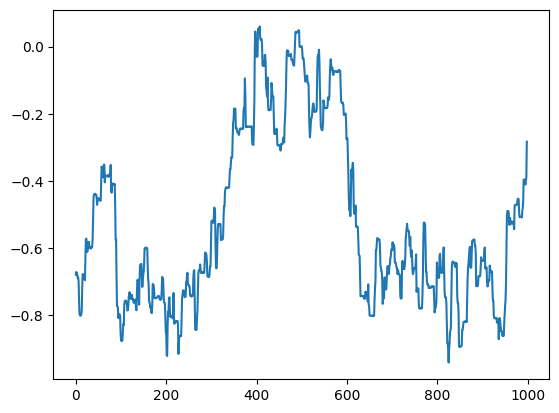

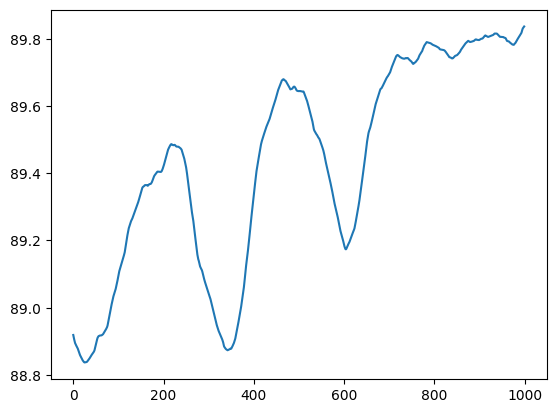

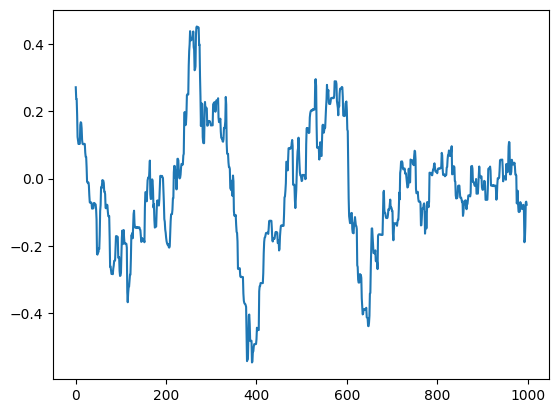

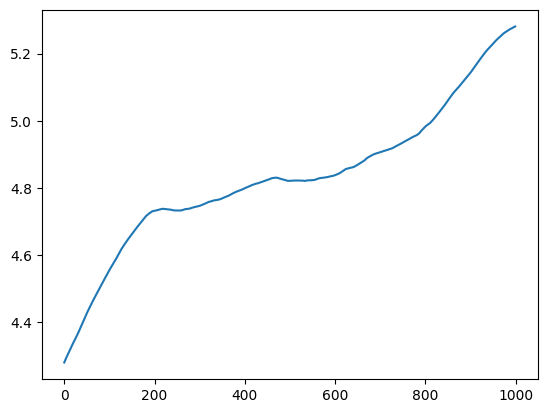

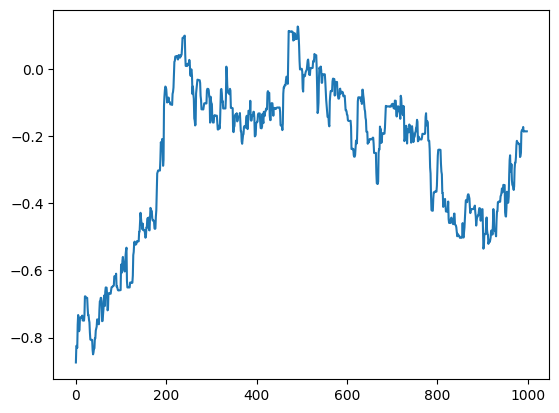

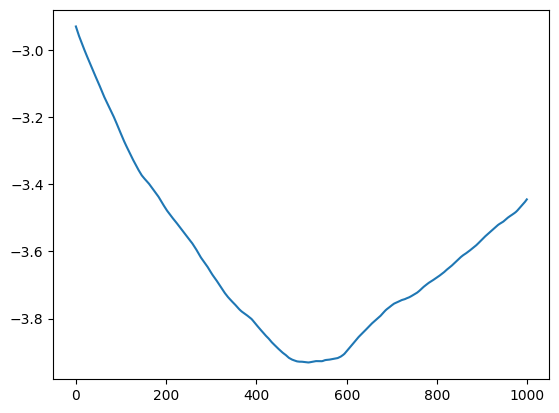

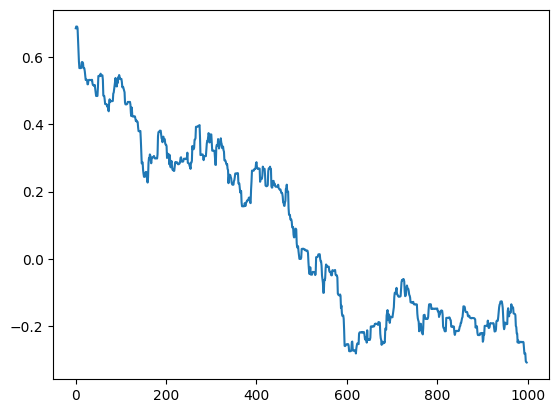

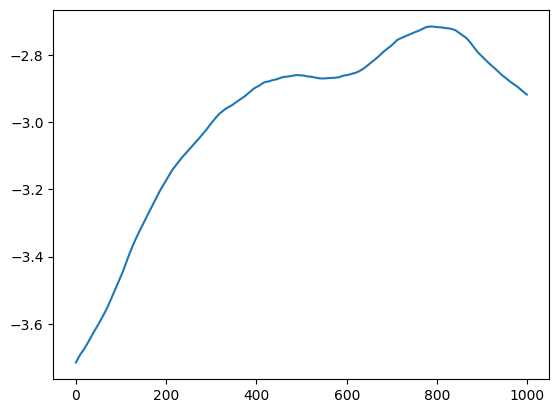

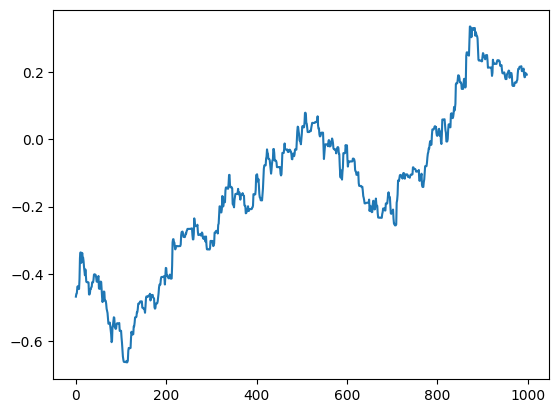

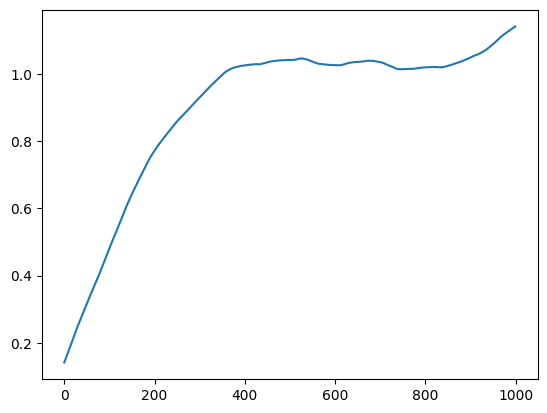

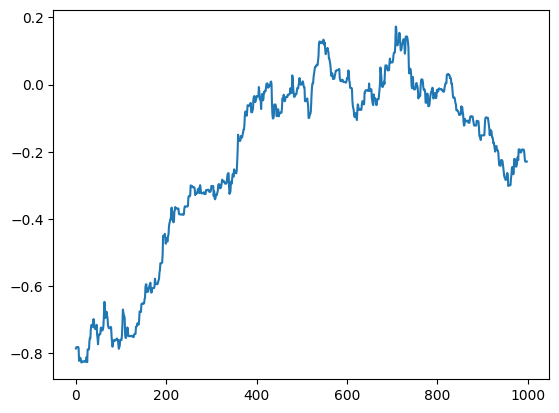

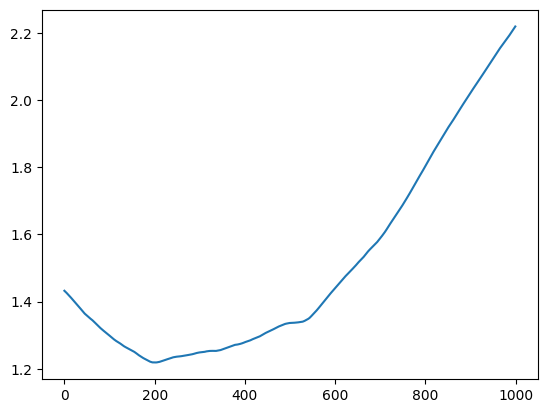

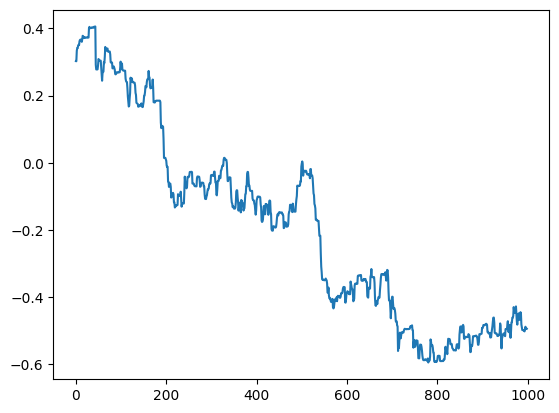

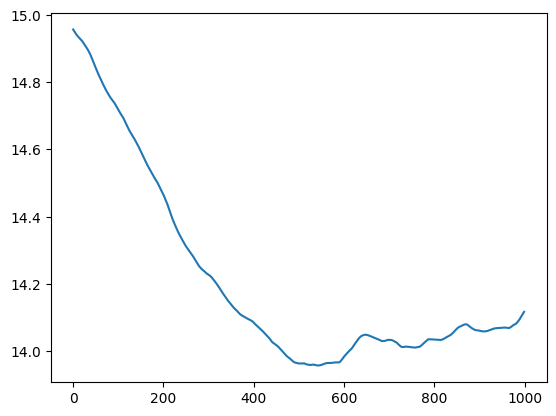

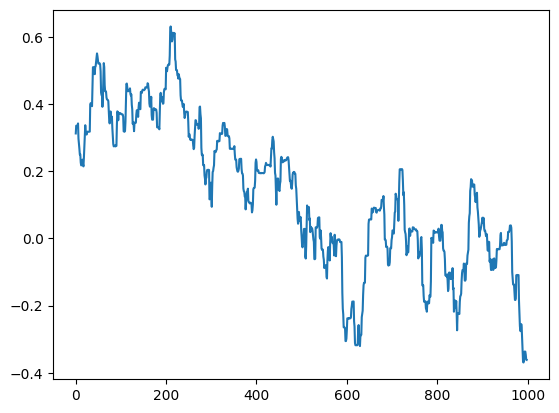

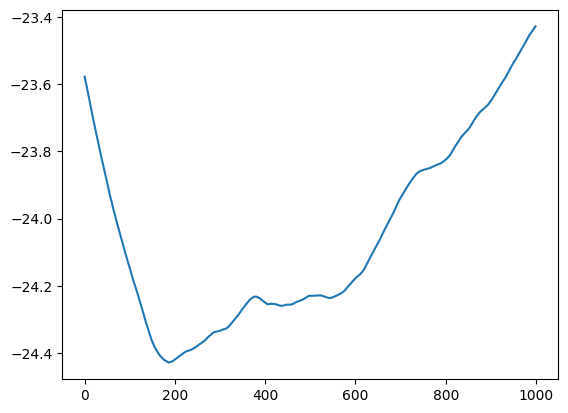

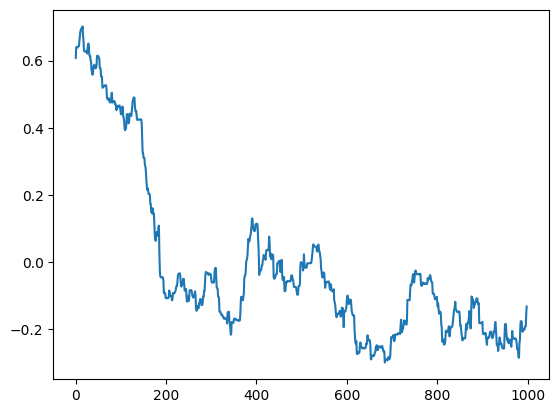

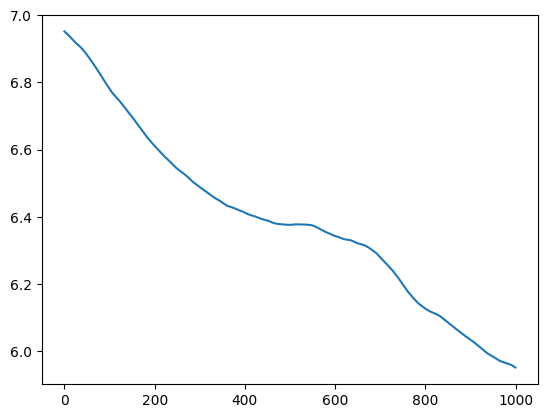

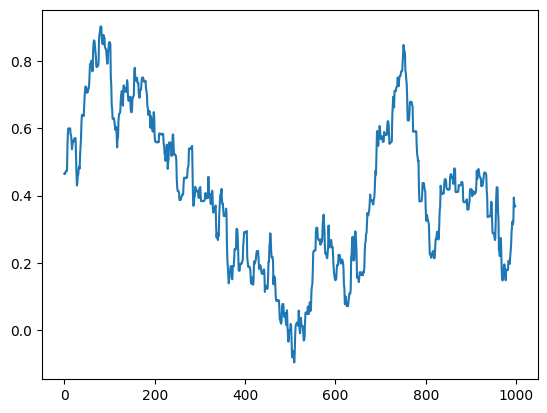

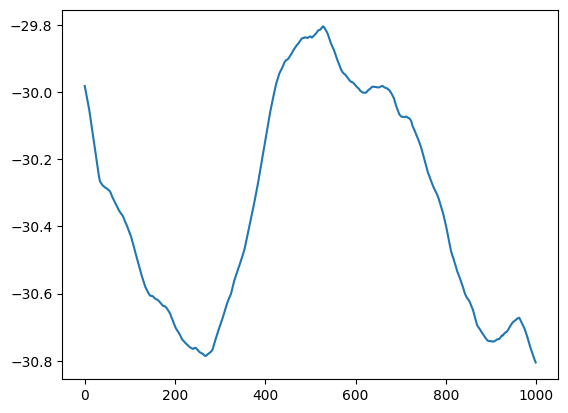

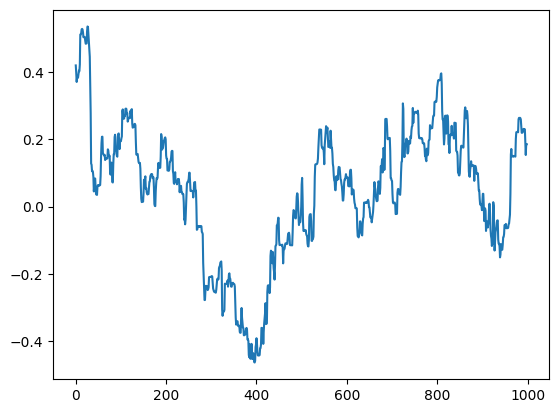

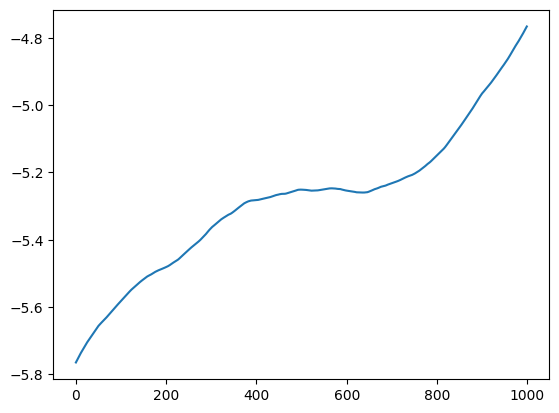

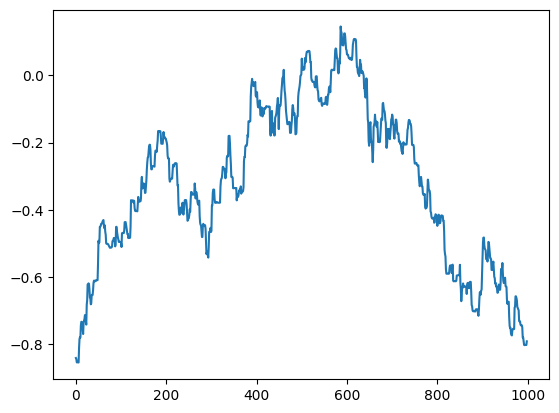

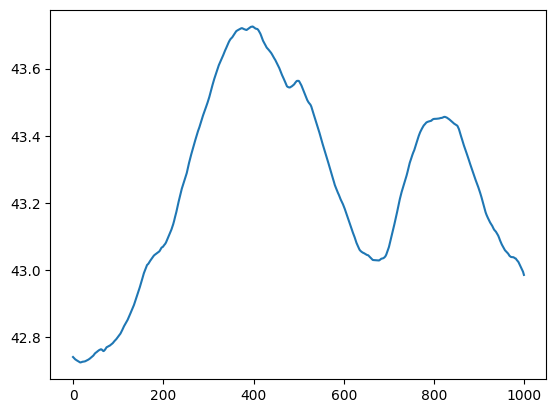

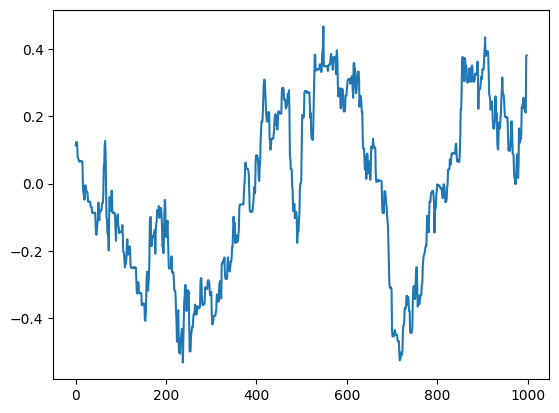

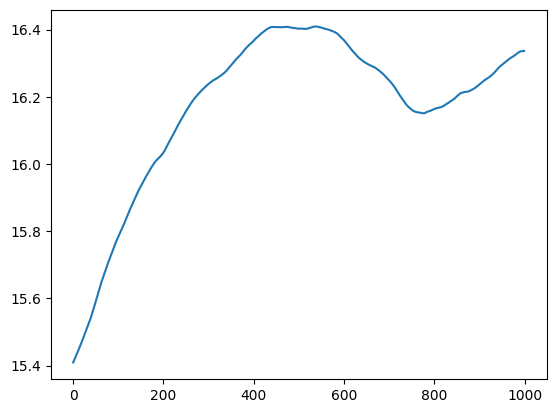

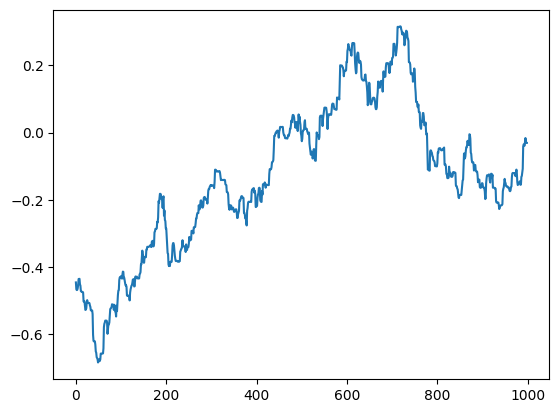

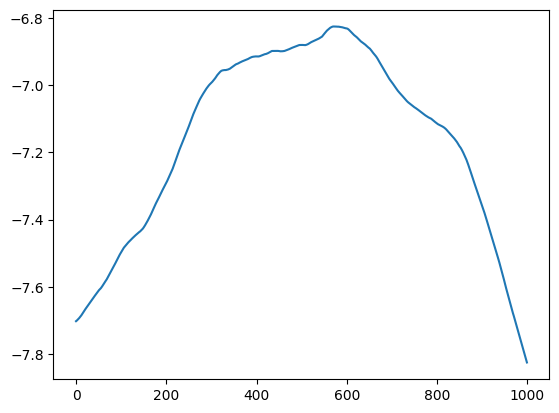

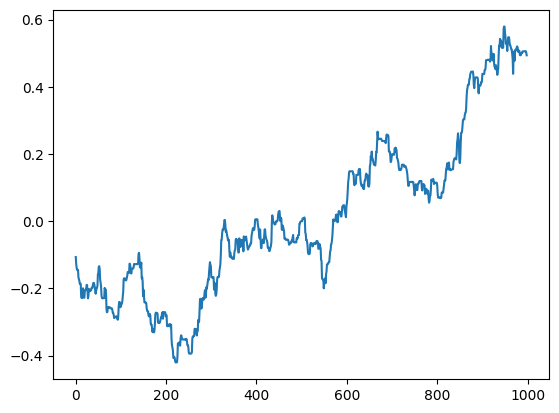

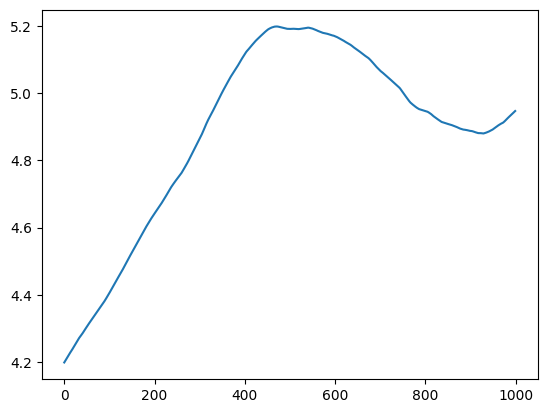

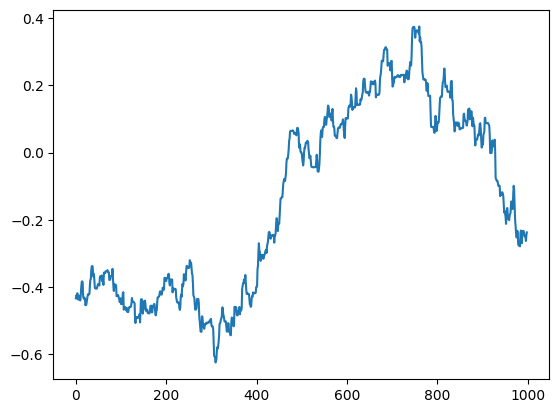

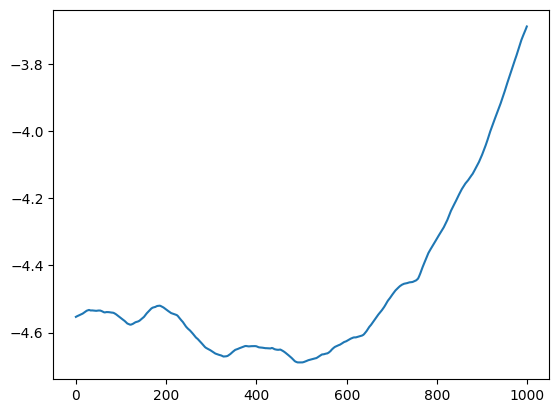

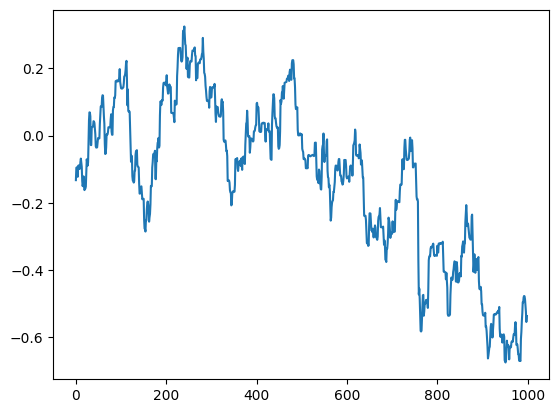

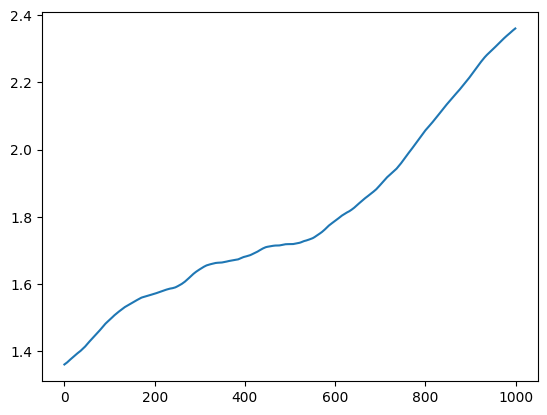

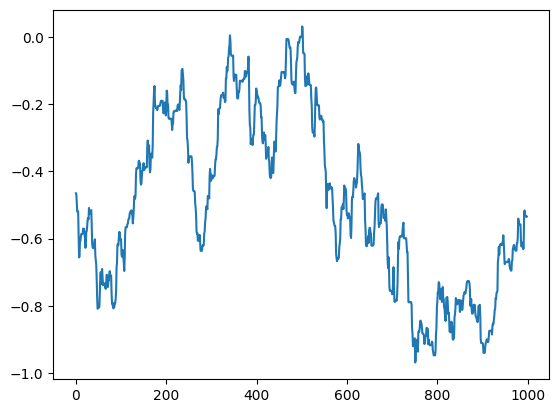

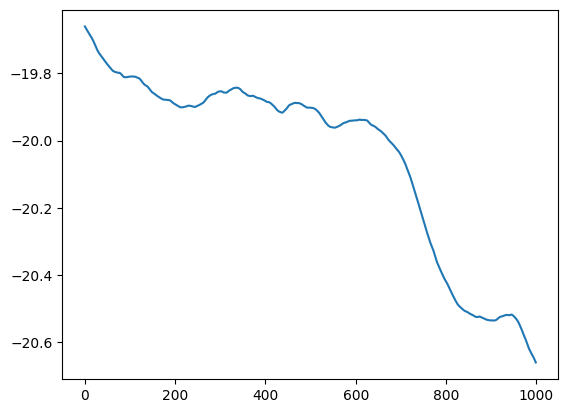

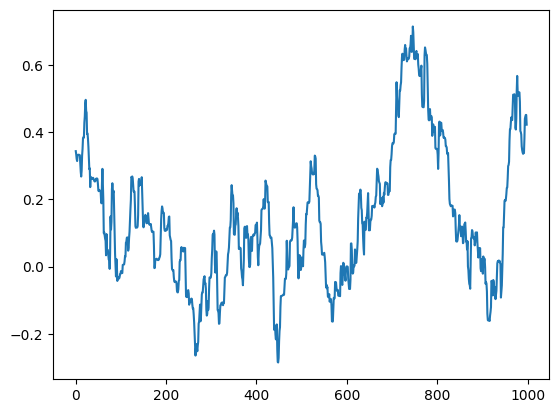

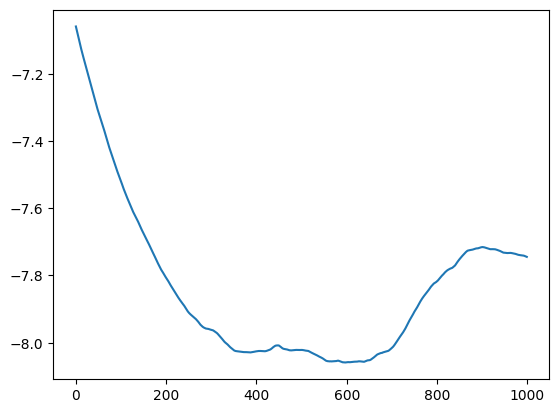

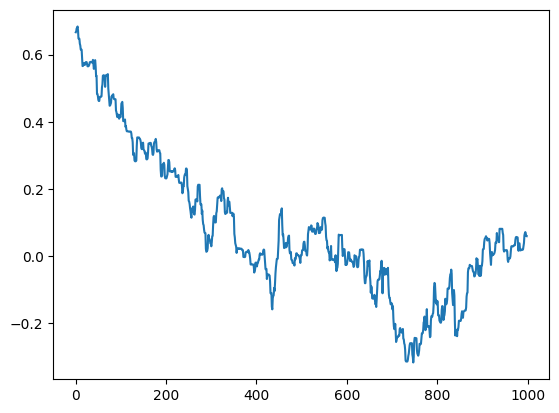

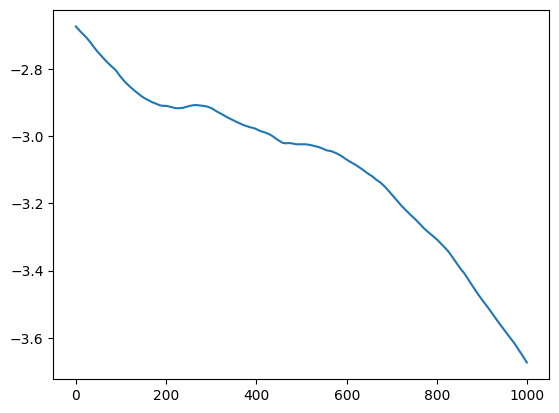

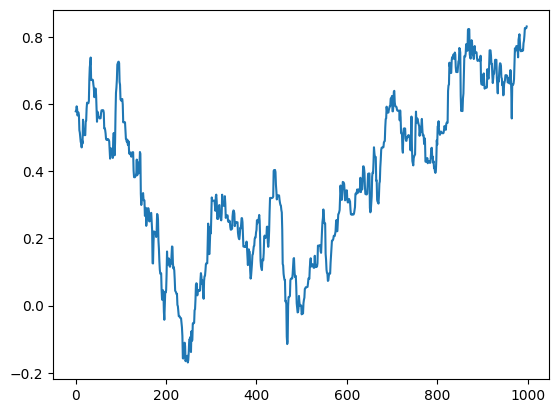

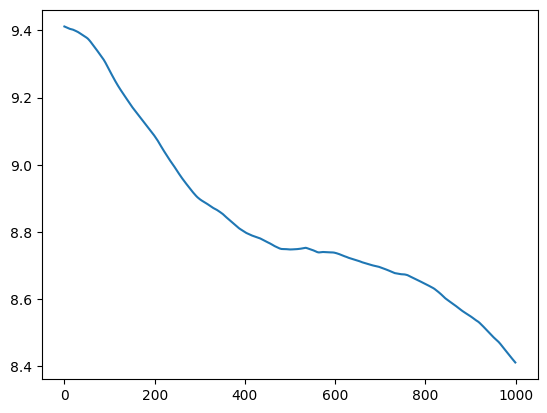

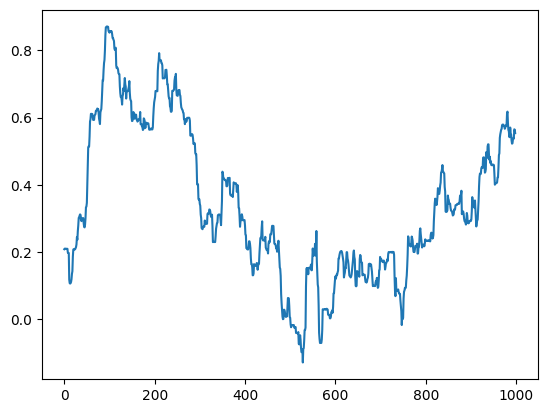

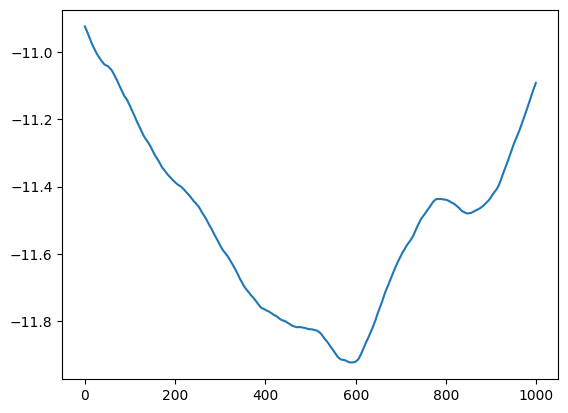

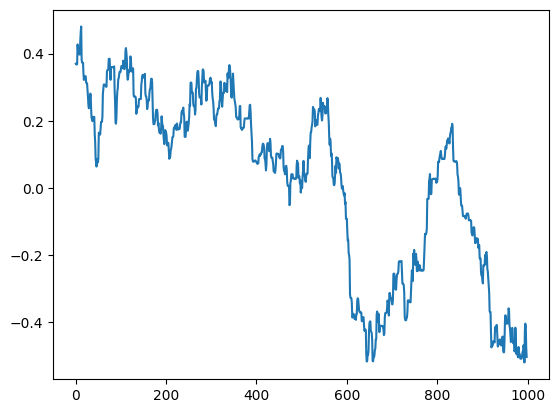

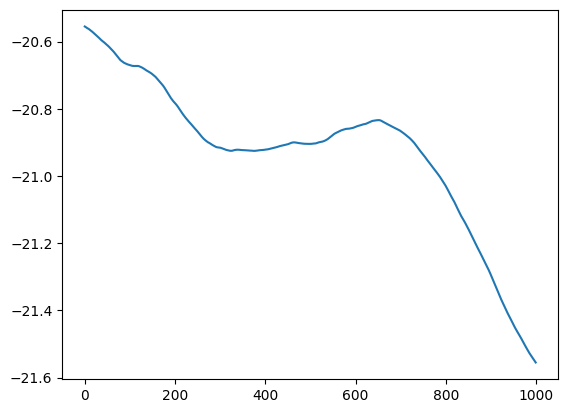

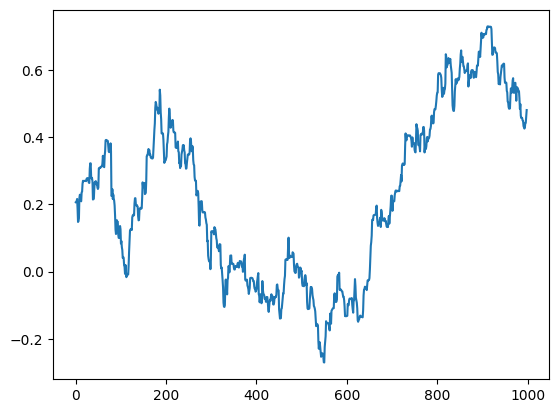

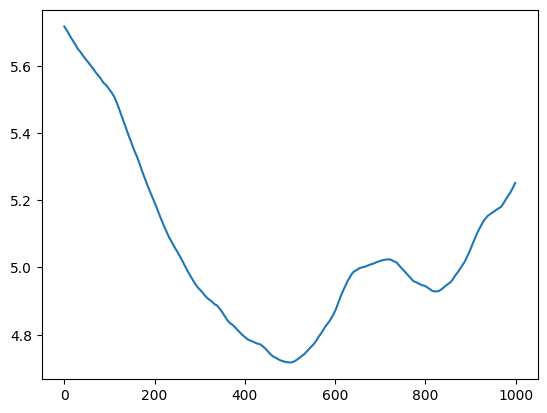

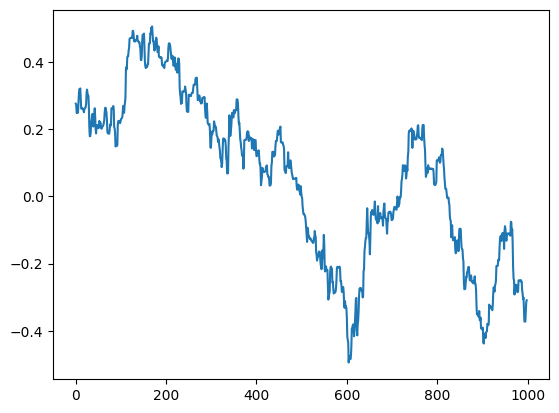

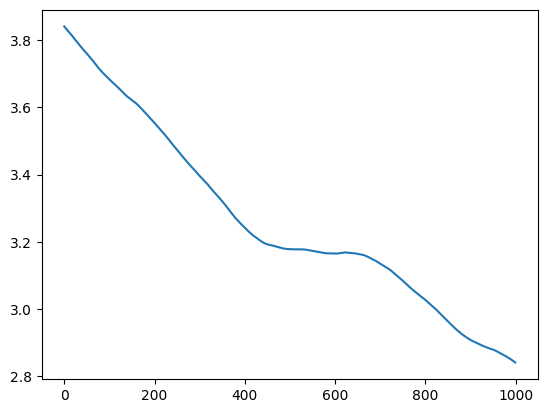

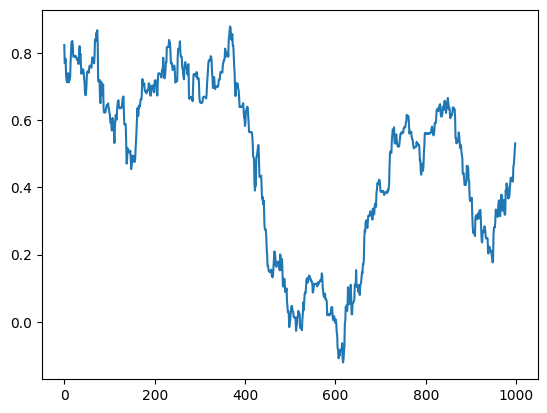

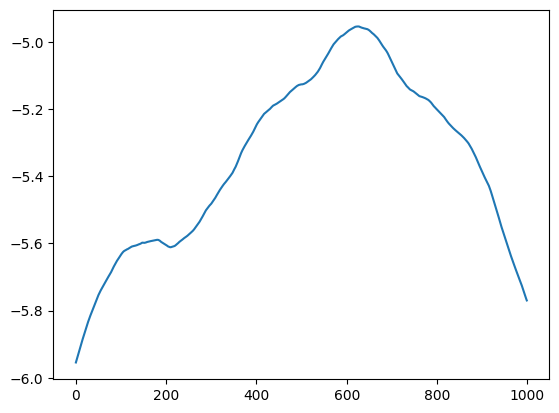

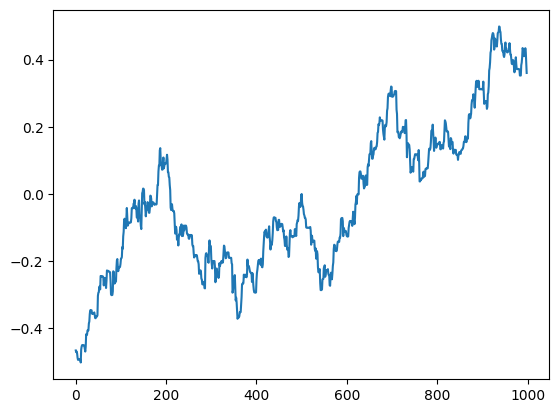

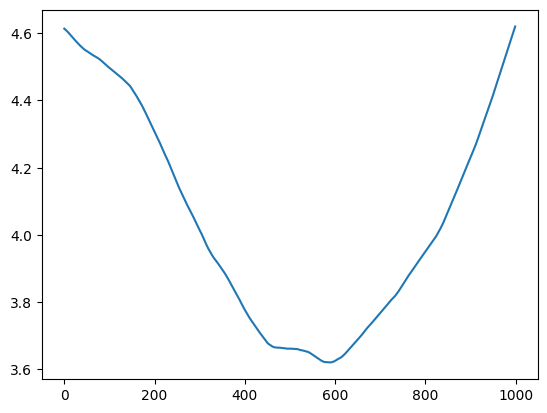

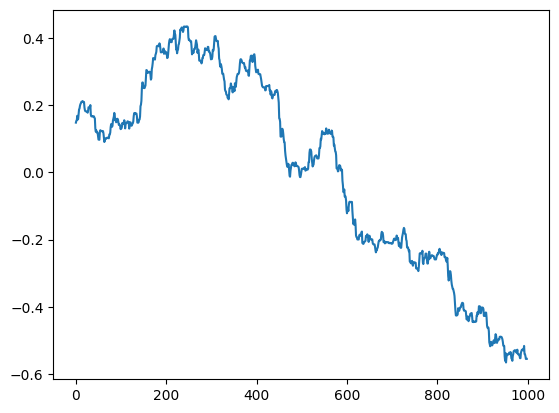

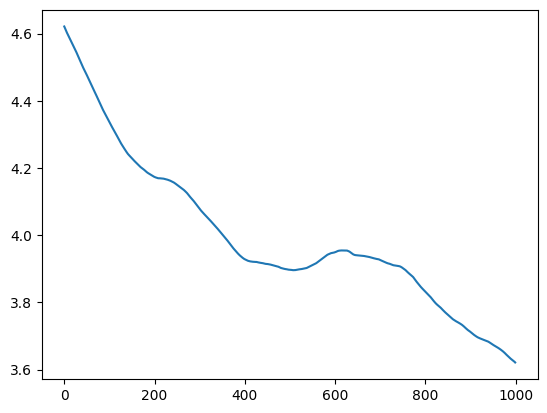

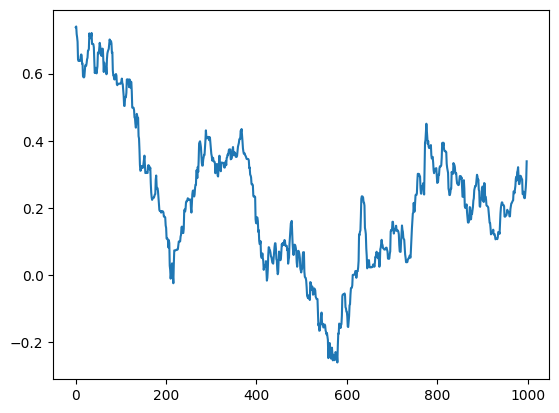

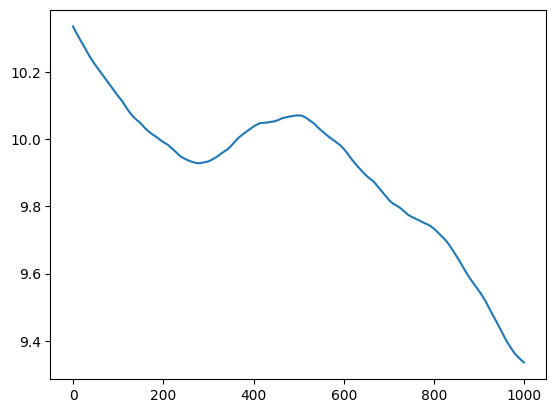

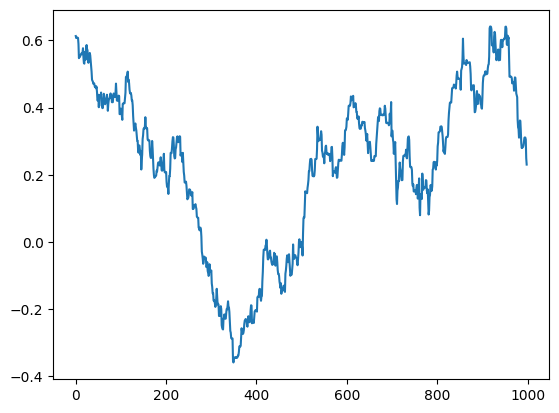

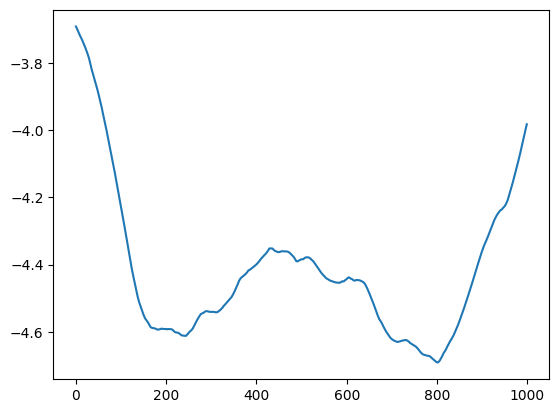

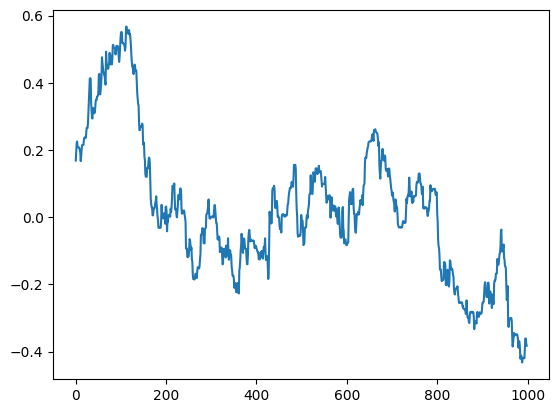

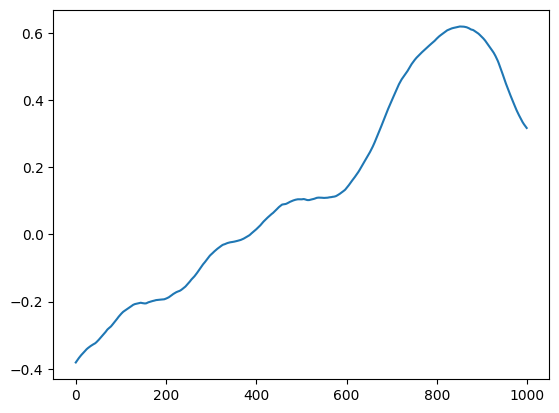

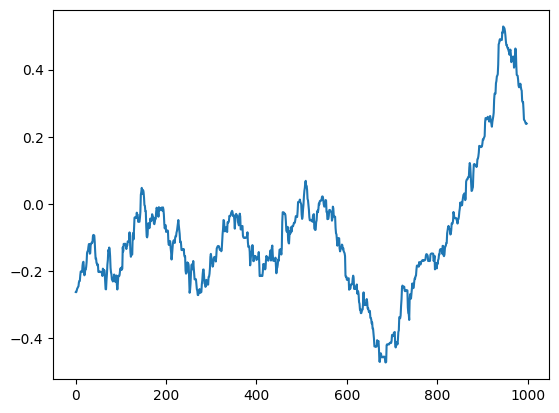

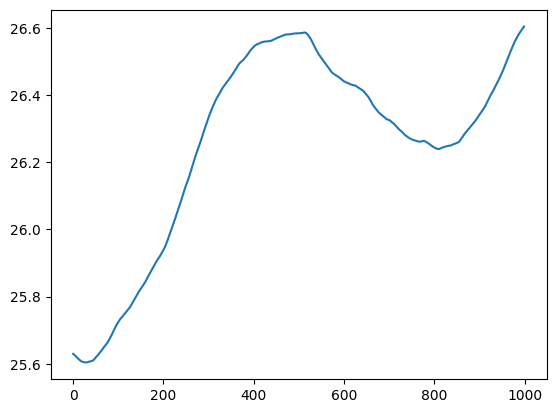

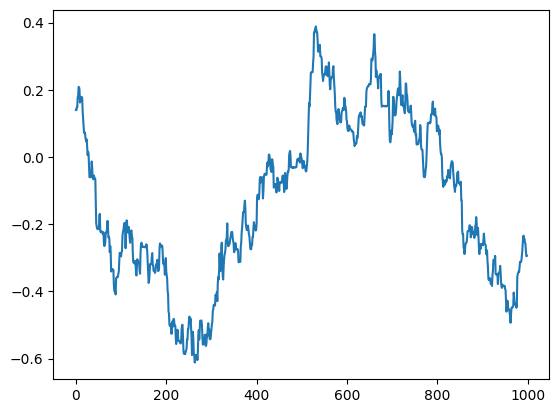

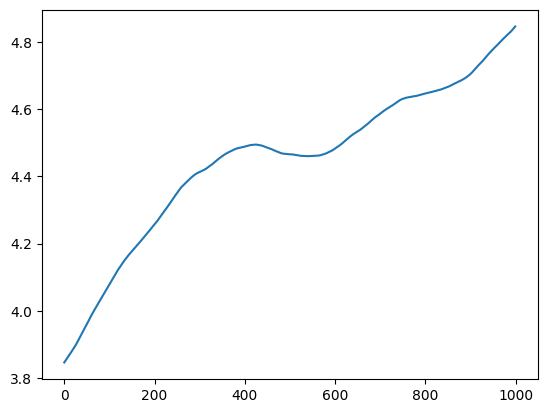

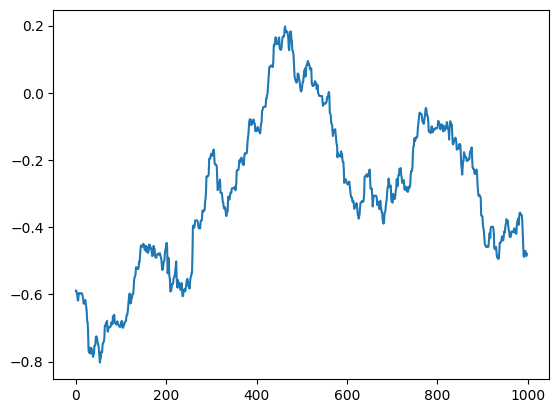

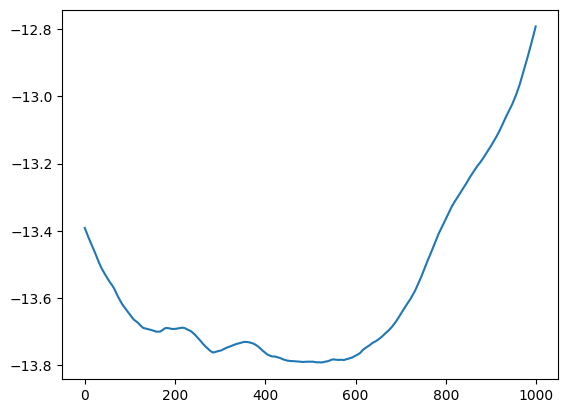

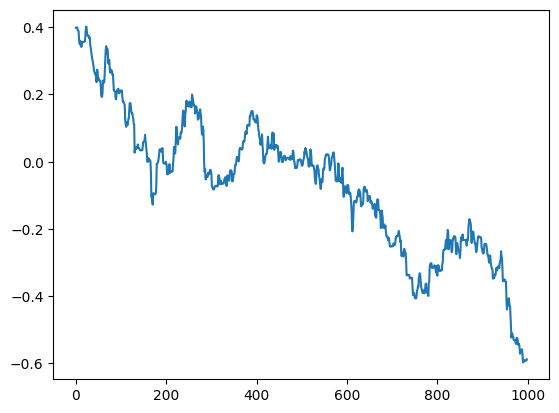

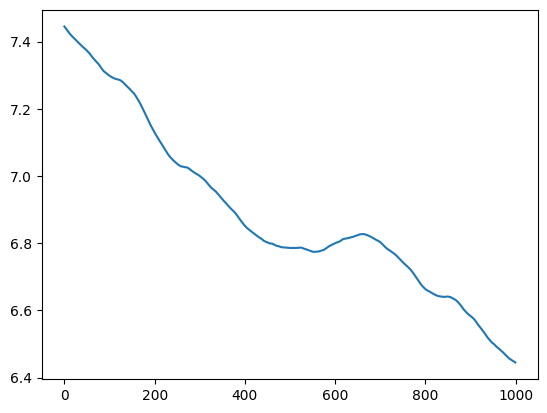

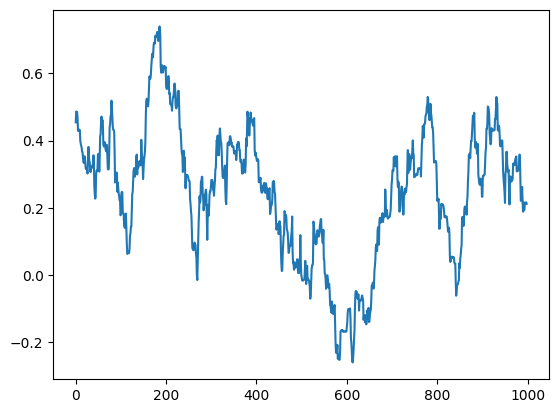

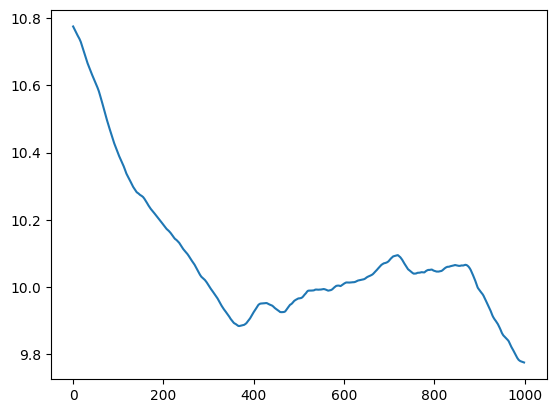

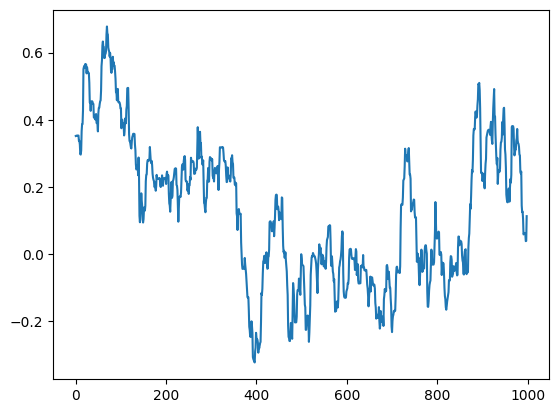

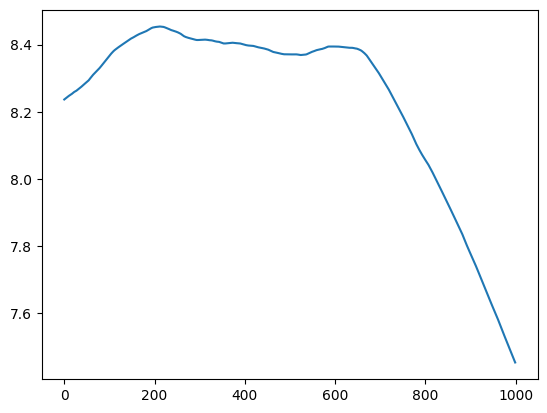

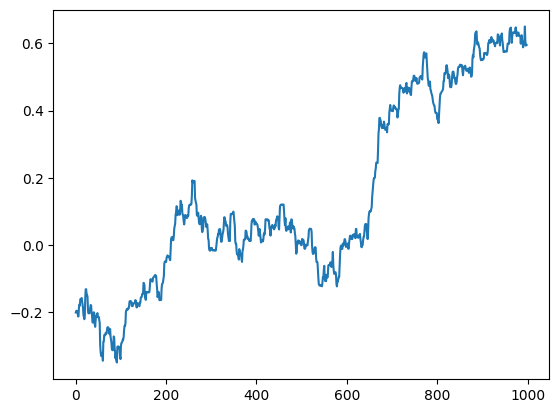

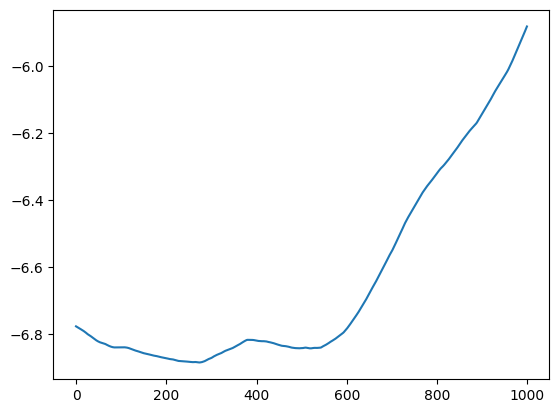

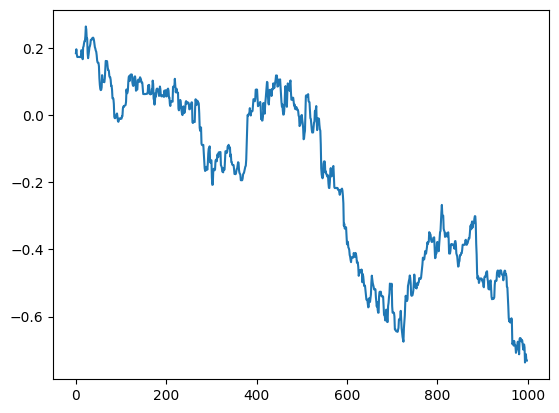

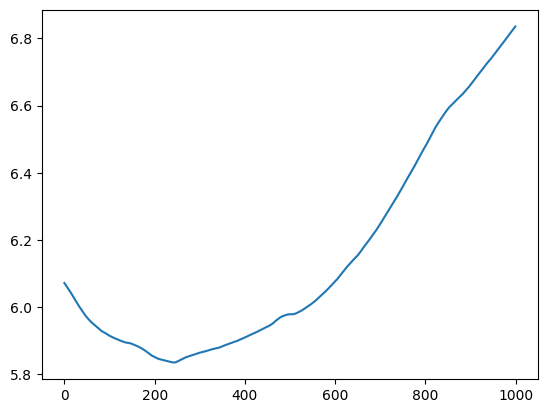

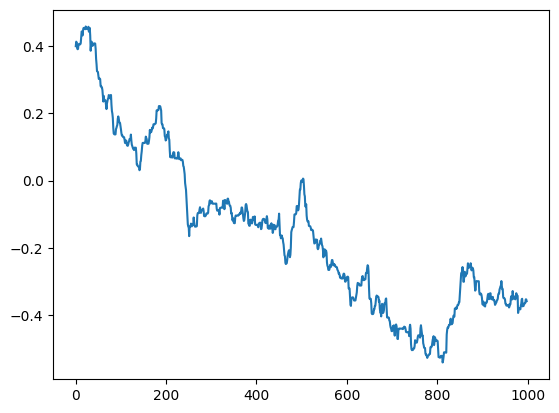

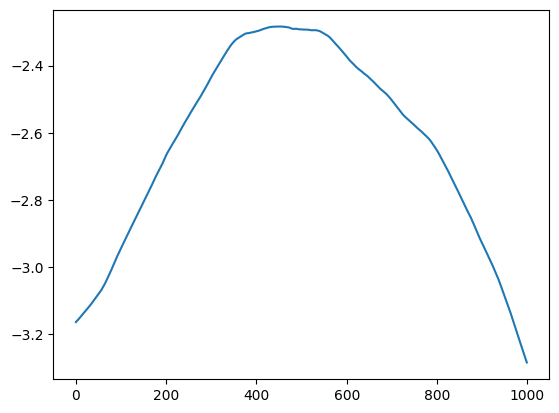

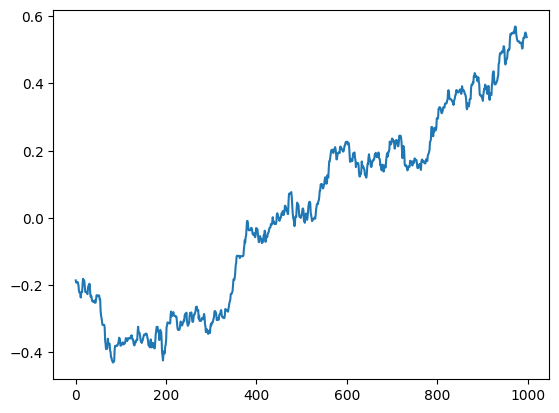

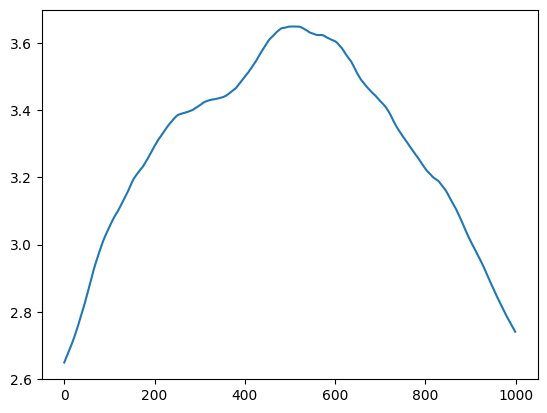

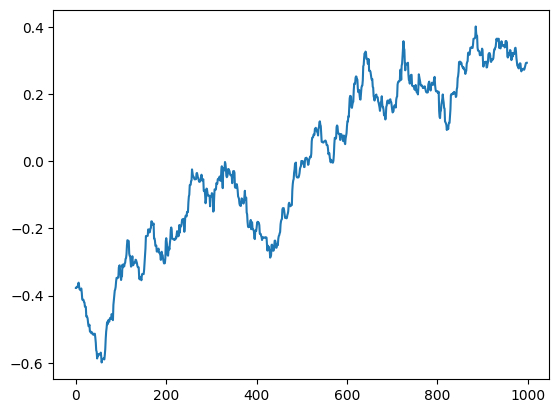

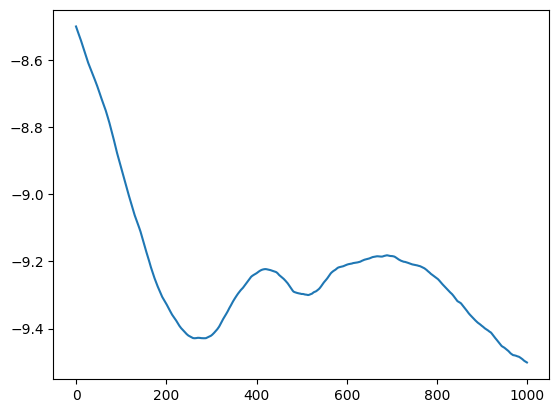

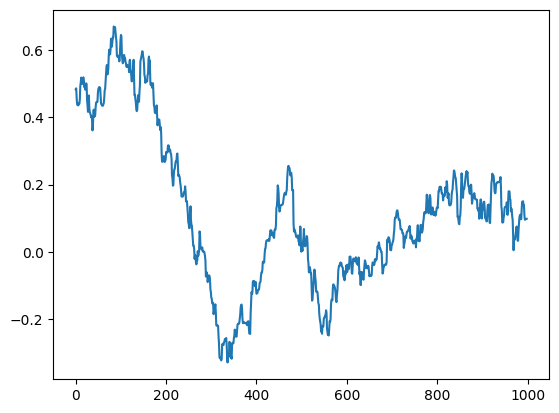

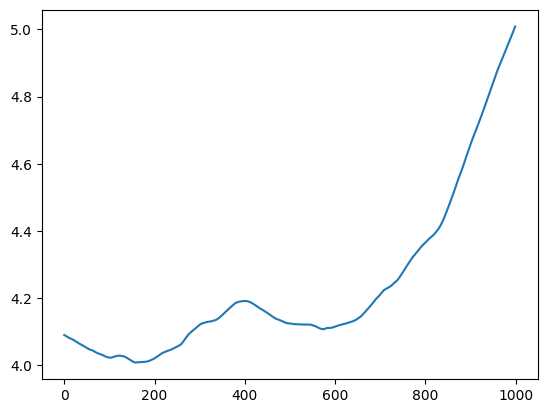

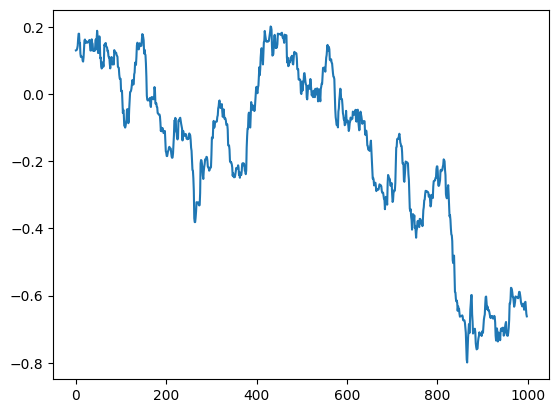

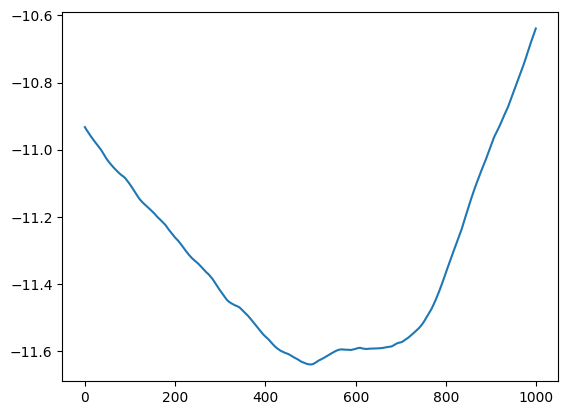

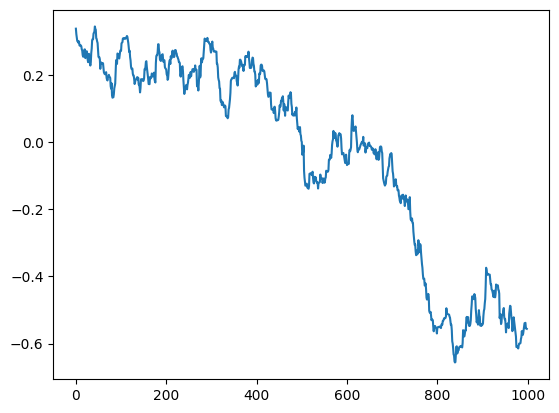

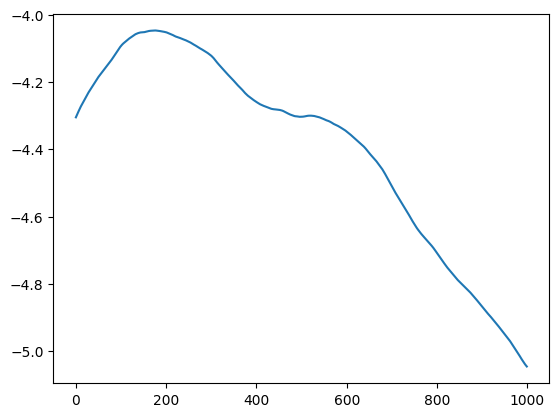

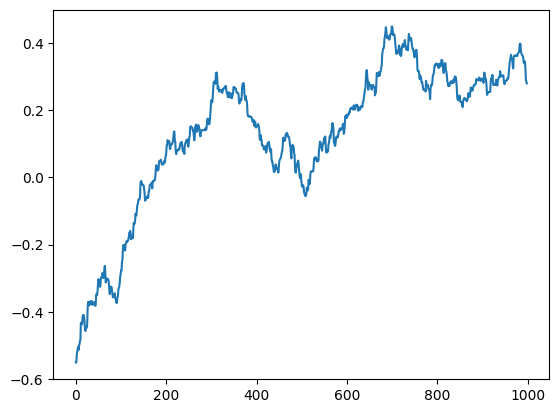

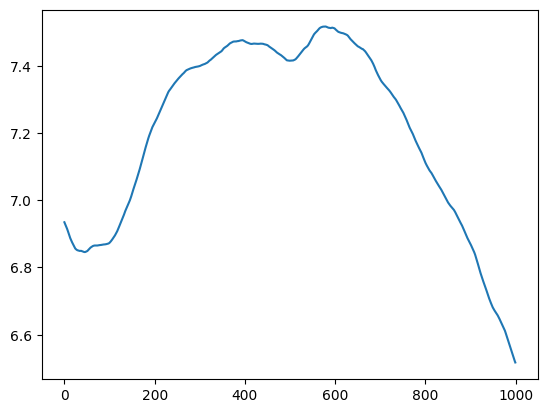

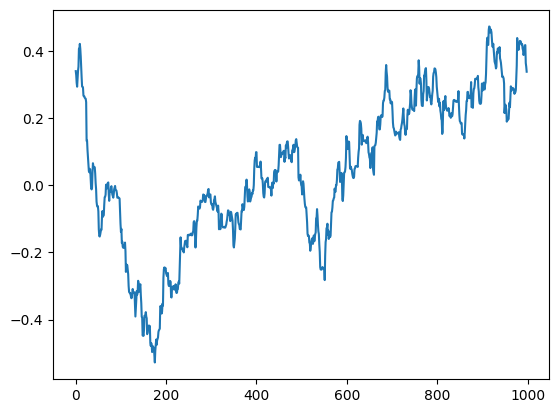

In [36]:
%%capture

# Movie_1D
np.random.seed(2021)

d, l, r = 1, 10, 1 # dimension, lenght, radius
area_sphere = (2 * np.pi) ** (d / 2) / gamma((d / 2)) * r ** (d - 1) # the area of a 2-sphere
area_cylinder = area_sphere * l # the area of the 3-cylinder of length l
tst = 0
eps = 1e-7

for lmbda in [i for i in range(5, 10)] + [i for i in range(25, 1000, 25)] + [i for i in range(1000, 5000, 50)]:
    lam_pois = lmbda # * area_cylinder

    K = np.random.poisson(lam=lam_pois)
    A_k = np.random.normal(0, K, size=(K)) # Impulsions magnitude

    X = np.random.normal(0, 1, size=(K, d))
    Xi = r * X / np.linalg.norm(X, 2, axis=1)[:, None] # Uniformly distributed over the hyper-sphere
    t = np.random.uniform(-l/2, l/2, size=(K))

    b_0 = - A_k * (np.abs(t) - t) / 2 
    b_0 = b_0.sum()
    b = - A_k[:, None] * (1 + np.sign(t))[:, None] * Xi / 2
    b = np.sum(b, axis=0)

    cpwl_network = cpwl_net(d, K)
    cpwl_network.set_weigh_bias(Xi, t, A_k)

    nx = 1000
    coords = np.linspace(-1, 1, nx).reshape((nx, 1)) # recheck this range

    vals = b_0 + coords * b + cpwl_network(torch.from_numpy(coords).float()).numpy() # if tst == 0 else vals + b_0 + coords @ b + cpwl_network(torch.from_numpy(coords).float()).numpy()
    vals_image = vals.T[0]
    vals_image = (vals_image + eps) / (np.max(vals) - np.min(vals) + eps)

    plt.figure()
    plt.plot(vals_image)
    plt.savefig(f'movie_1D/img_{lmbda}.png')

    grad = vals_image[:-1] - vals_image[1:]
    grad = (grad + eps) / (np.max(grad) - np.min(grad) + eps)

    plt.figure()
    plt.plot(grad)
    plt.savefig(f'movie_1D/grd_{lmbda}.png')

In [ ]:
## 3D plots

np.random.seed(2021)

d, l, r = 2, 1, 1 # dimension, lenght, radius
area_sphere = (2 * np.pi) ** (d / 2) / gamma((d / 2)) * r ** (d - 1) # the area of a 2-sphere
area_cylinder = area_sphere * l # the area of the 3-cylinder of length l
lmbda = 5

for i in range(5):
    lam_pois = lmbda * area_cylinder

    K = np.random.poisson(lam=lam_pois)
    A_k = np.random.normal(0, 2, size=(K)) # Impulsions magnitude

    X = np.random.normal(0, 1, size=(K, d))
    Xi = r * X / np.linalg.norm(X, 2, axis=1)[:, None] # Uniformly distributed over the hyper-sphere
    t = np.random.uniform(-l/2, l/2, size=(K))

    b_0 = - A_k * (np.abs(t) - t) / 2 
    b_0 = b_0.sum()
    b = - A_k[:, None] * (1 + np.sign(t))[:, None] * Xi / 2
    b = np.sum(b, axis=0)[:, None]
    
    cpwl_network = cpwl_net(d, K)
    cpwl_network.set_weigh_bias(Xi, t, A_k)

    nx, ny = (20, 20)
    x = np.linspace(-2, 2, nx) # recheck this range
    y = np.linspace(-2, 2, ny) # recheck this range
    xv, yv = np.meshgrid(x, y)
    coords = np.concatenate((xv.flatten()[:, None], yv.flatten() [:, None]), axis=1)

    vals = b_0 + coords @ b + cpwl_network(torch.from_numpy(coords).float()).numpy()
    vals_image = np.fliplr(vals.reshape((nx, ny)))
    vals_image = (vals_image - np.min(vals)) / (np.max(vals) - np.min(vals))
    
    tri = MyDelaunay(coords, vals)

    grads = tri.lat_coeffs
    grad_norms = np.linalg.norm(grads, 2, axis=1)

    plot_with_gradient_map(tri, 1.15, 1.15, 0.4, save_plot=True, ref="grad_images/threed_up.pdf")

                       
    plt.imsave('images/grad' + str(i) + '.png', np.log(vals_image)[:1080, :1920])

KeyboardInterrupt: 